Import & StatType Class Definition

In [83]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from enum import Enum
import scipy.stats
import matplotlib.cm as cm
from omnetpp.scave import results, chart, utils

class StatType(Enum):
    SCALAR = "count"
    VECTOR = "vector"

Script Parameters

In [84]:
mpl.rcParams['figure.dpi'] = 300
relPath = "../results/"

DEBUG = True

isDos = True
simName = "MMS_MITM_5G"

rep = 30
simTimeLimit = 120
numClients = 1
numServers = 2

In [85]:
fileNamesSca = []
fileNamesVec = []

cliMeasNames = [("readResponseReceivedTime", StatType.VECTOR), ("commandResponseReceivedTime", StatType.VECTOR), ("measureReceivedAmount", StatType.VECTOR), ("readSent", StatType.SCALAR), ("commandSent", StatType.SCALAR), ("readResponse", StatType.SCALAR), 
             ("commandResponse", StatType.SCALAR), ("readResponseTimeout", StatType.SCALAR), ("commandResponseTimeout", StatType.SCALAR)]
evilMeasNames = [("measureBlock", StatType.SCALAR), ("measureCompromised", StatType.SCALAR), ("readRequestBlock", StatType.SCALAR), ("readRequestCompromised", StatType.SCALAR), 
                 ("commandRequestBlock", StatType.SCALAR), ("commandRequestCompromised", StatType.SCALAR), ("readResponseBlock", StatType.SCALAR), ("readResponseCompromised", StatType.SCALAR),
                 ("commandResponseBlock", StatType.SCALAR), ("commandResponseCompromised", StatType.SCALAR)]

for i in range(0,rep):
    fileNamesSca.append(relPath + simName + '-#' + i.__str__() + '.sca')
    fileNamesVec.append(relPath + simName + '-#' + i.__str__() + '.vec')
    

if DEBUG:
    print(fileNamesSca)
    print(fileNamesVec)


['../results/MMS_MITM_5G_DER_Atk_Delayed-#0.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#1.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#2.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#3.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#4.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#5.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#6.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#7.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#8.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#9.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#10.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#11.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#12.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#13.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#14.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#15.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#16.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#17.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#18.sca', '../results/MMS_MITM_5G_DER_Atk_Delayed-#19.sca', '../resul

Function to create the statistics filter

In [86]:
def createFilter(measNames):
    filter = ""##"type =~ \"scalar\" AND ("
    for i in range(len(measNames)):
        if i != len(measNames)-1:
            filter += "name =~ \"*" + measNames[i][0] + ":" + measNames[i][1].value + "\" OR "
        else:
            filter += "name =~ \"*" + measNames[i][0] + ":" + measNames[i][1].value + "\""##)"
    return filter

In [87]:
dataSca = results.read_result_files(fileNamesSca, filter_expression=createFilter(cliMeasNames + evilMeasNames))
dataVec = results.read_result_files(fileNamesVec, filter_expression=createFilter(cliMeasNames + evilMeasNames))
vec = results.get_vectors(dataVec)
scl = results.get_scalars(dataSca)

if DEBUG:
    print(createFilter(cliMeasNames + evilMeasNames))
    scl.to_csv("./outSC.csv", mode="w", header=True)
    vec.to_csv("./outVC.csv", mode="w", header=True)

name =~ "*readResponseReceivedTime:vector" OR name =~ "*commandResponseReceivedTime:vector" OR name =~ "*measureReceivedAmount:vector" OR name =~ "*readSent:count" OR name =~ "*commandSent:count" OR name =~ "*readResponse:count" OR name =~ "*commandResponse:count" OR name =~ "*readResponseTimeout:count" OR name =~ "*commandResponseTimeout:count" OR name =~ "*measureBlock:count" OR name =~ "*measureCompromised:count" OR name =~ "*readRequestBlock:count" OR name =~ "*readRequestCompromised:count" OR name =~ "*commandRequestBlock:count" OR name =~ "*commandRequestCompromised:count" OR name =~ "*readResponseBlock:count" OR name =~ "*readResponseCompromised:count" OR name =~ "*commandResponseBlock:count" OR name =~ "*commandResponseCompromised:count"


Plot client measures for each client aggregating all the repetitions 

In [88]:
def plotBoxWiskerSca(measNames, numClients, numServers, title = "", xLab = "", yLab = "", cli = "client"): 
    plt.rcParams.update({'font.size': 12})   
    outVec = list()
    for i in range(numClients):
        for j in range(numServers):
            box = pd.DataFrame()
            for meas in measNames:
                strElem = ""
                if cli == "evilClient":
                    strElem = cli + ".app[" + str(j) + "]"
                else:
                    strElem = cli + "[" + str(i) + "].app[" + str(j) + "]"
                
                if meas[1] == StatType.SCALAR:
                    flt = scl[scl["name"].str.contains(meas[0] + ":" + meas[1].value)]
                    flt = flt[flt["module"].str.endswith(strElem)]
                    box[meas[0]] = flt["value"].reset_index(drop=True)
                 
            box = box.replace(np.nan, 0)
            outVec.append(box)
            if DEBUG:
                box.to_csv("./out.csv", mode="w", header=True)
            box.boxplot(grid=False, rot=90)
            plt.rcParams["figure.figsize"] = (9,6)
            plt.title(title + " (" + strElem + ")")
            plt.xlabel(xLab)
            plt.ylabel(yLab)
            plt.show()
    return outVec

In [89]:
def plotBoxWiskerVec(numClients, numServers, title = "", xLab = "", yLab = "", cli = "client", vecMeasName = "measureReceivedAmount", numRanges = 0):
    plt.rcParams["figure.figsize"] = (9,6)
    
    ranges = list()
    if numRanges != 0:
        incr = simTimeLimit/numRanges
        nxt = 0
        while nxt+incr <= 120:
            ranges.append((nxt, nxt + incr))
            nxt += incr
    if DEBUG:
        print(ranges)
    
    outVec = list()
    for i in range(numClients):
        for j in range(numServers):
            strElem = ""
            if cli == "evilClient":
                strElem = cli + ".app[" + str(j) + "]"
            else:
                strElem = cli + "[" + str(i) + "].app[" + str(j) + "]"
            
            flt = vec[vec["name"].str.contains(vecMeasName + ":" + StatType.VECTOR.value)]
            flt = flt[flt["module"].str.endswith(strElem)]
            if numRanges == 0:   
                box = None
                rowNum = 0
                for row in flt.itertuples():
                    vecValue = pd.Series(row.vecvalue)
                    vecTime = pd.Series(row.vectime)
                    if box is None:
                        box = pd.DataFrame(columns=vecTime)
                    box.loc[rowNum] = vecValue.tolist()
                    rowNum += 1   
                                    
                box = box.replace(np.nan, 0)
                outVec.append(box)
                if DEBUG:
                    box.to_csv("./out.csv", mode="w", header=True)
                box.boxplot(grid=False, rot=90)
                plt.title(title + " (" + strElem + ")")
                plt.xlabel(xLab)
                plt.ylabel(yLab)
                plt.show()
            else:
                box = pd.DataFrame(columns=["value", "ranges"])
                rowNum = 0
                for row in flt.itertuples():
                    vecValue = pd.Series(row.vecvalue)
                    vecTime = pd.Series(row.vectime)
                    for val, time in zip(vecValue, vecTime):    
                        for rang in ranges:
                            if time > rang[0] and time <= rang[1]:
                                box.loc[rowNum] = list((val, rang))
                                rowNum += 1
                                break   
                                    
                outVec.append(box)
                if DEBUG:
                    box.to_csv("./out.csv", mode="w", header=True)
                box.boxplot(column="value", by="ranges", grid=False, rot=90)
                plt.suptitle('')
                plt.title(title + " (" + strElem + ")")
                plt.xlabel(xLab)
                plt.ylabel(yLab)
                plt.show()
                  
    return outVec

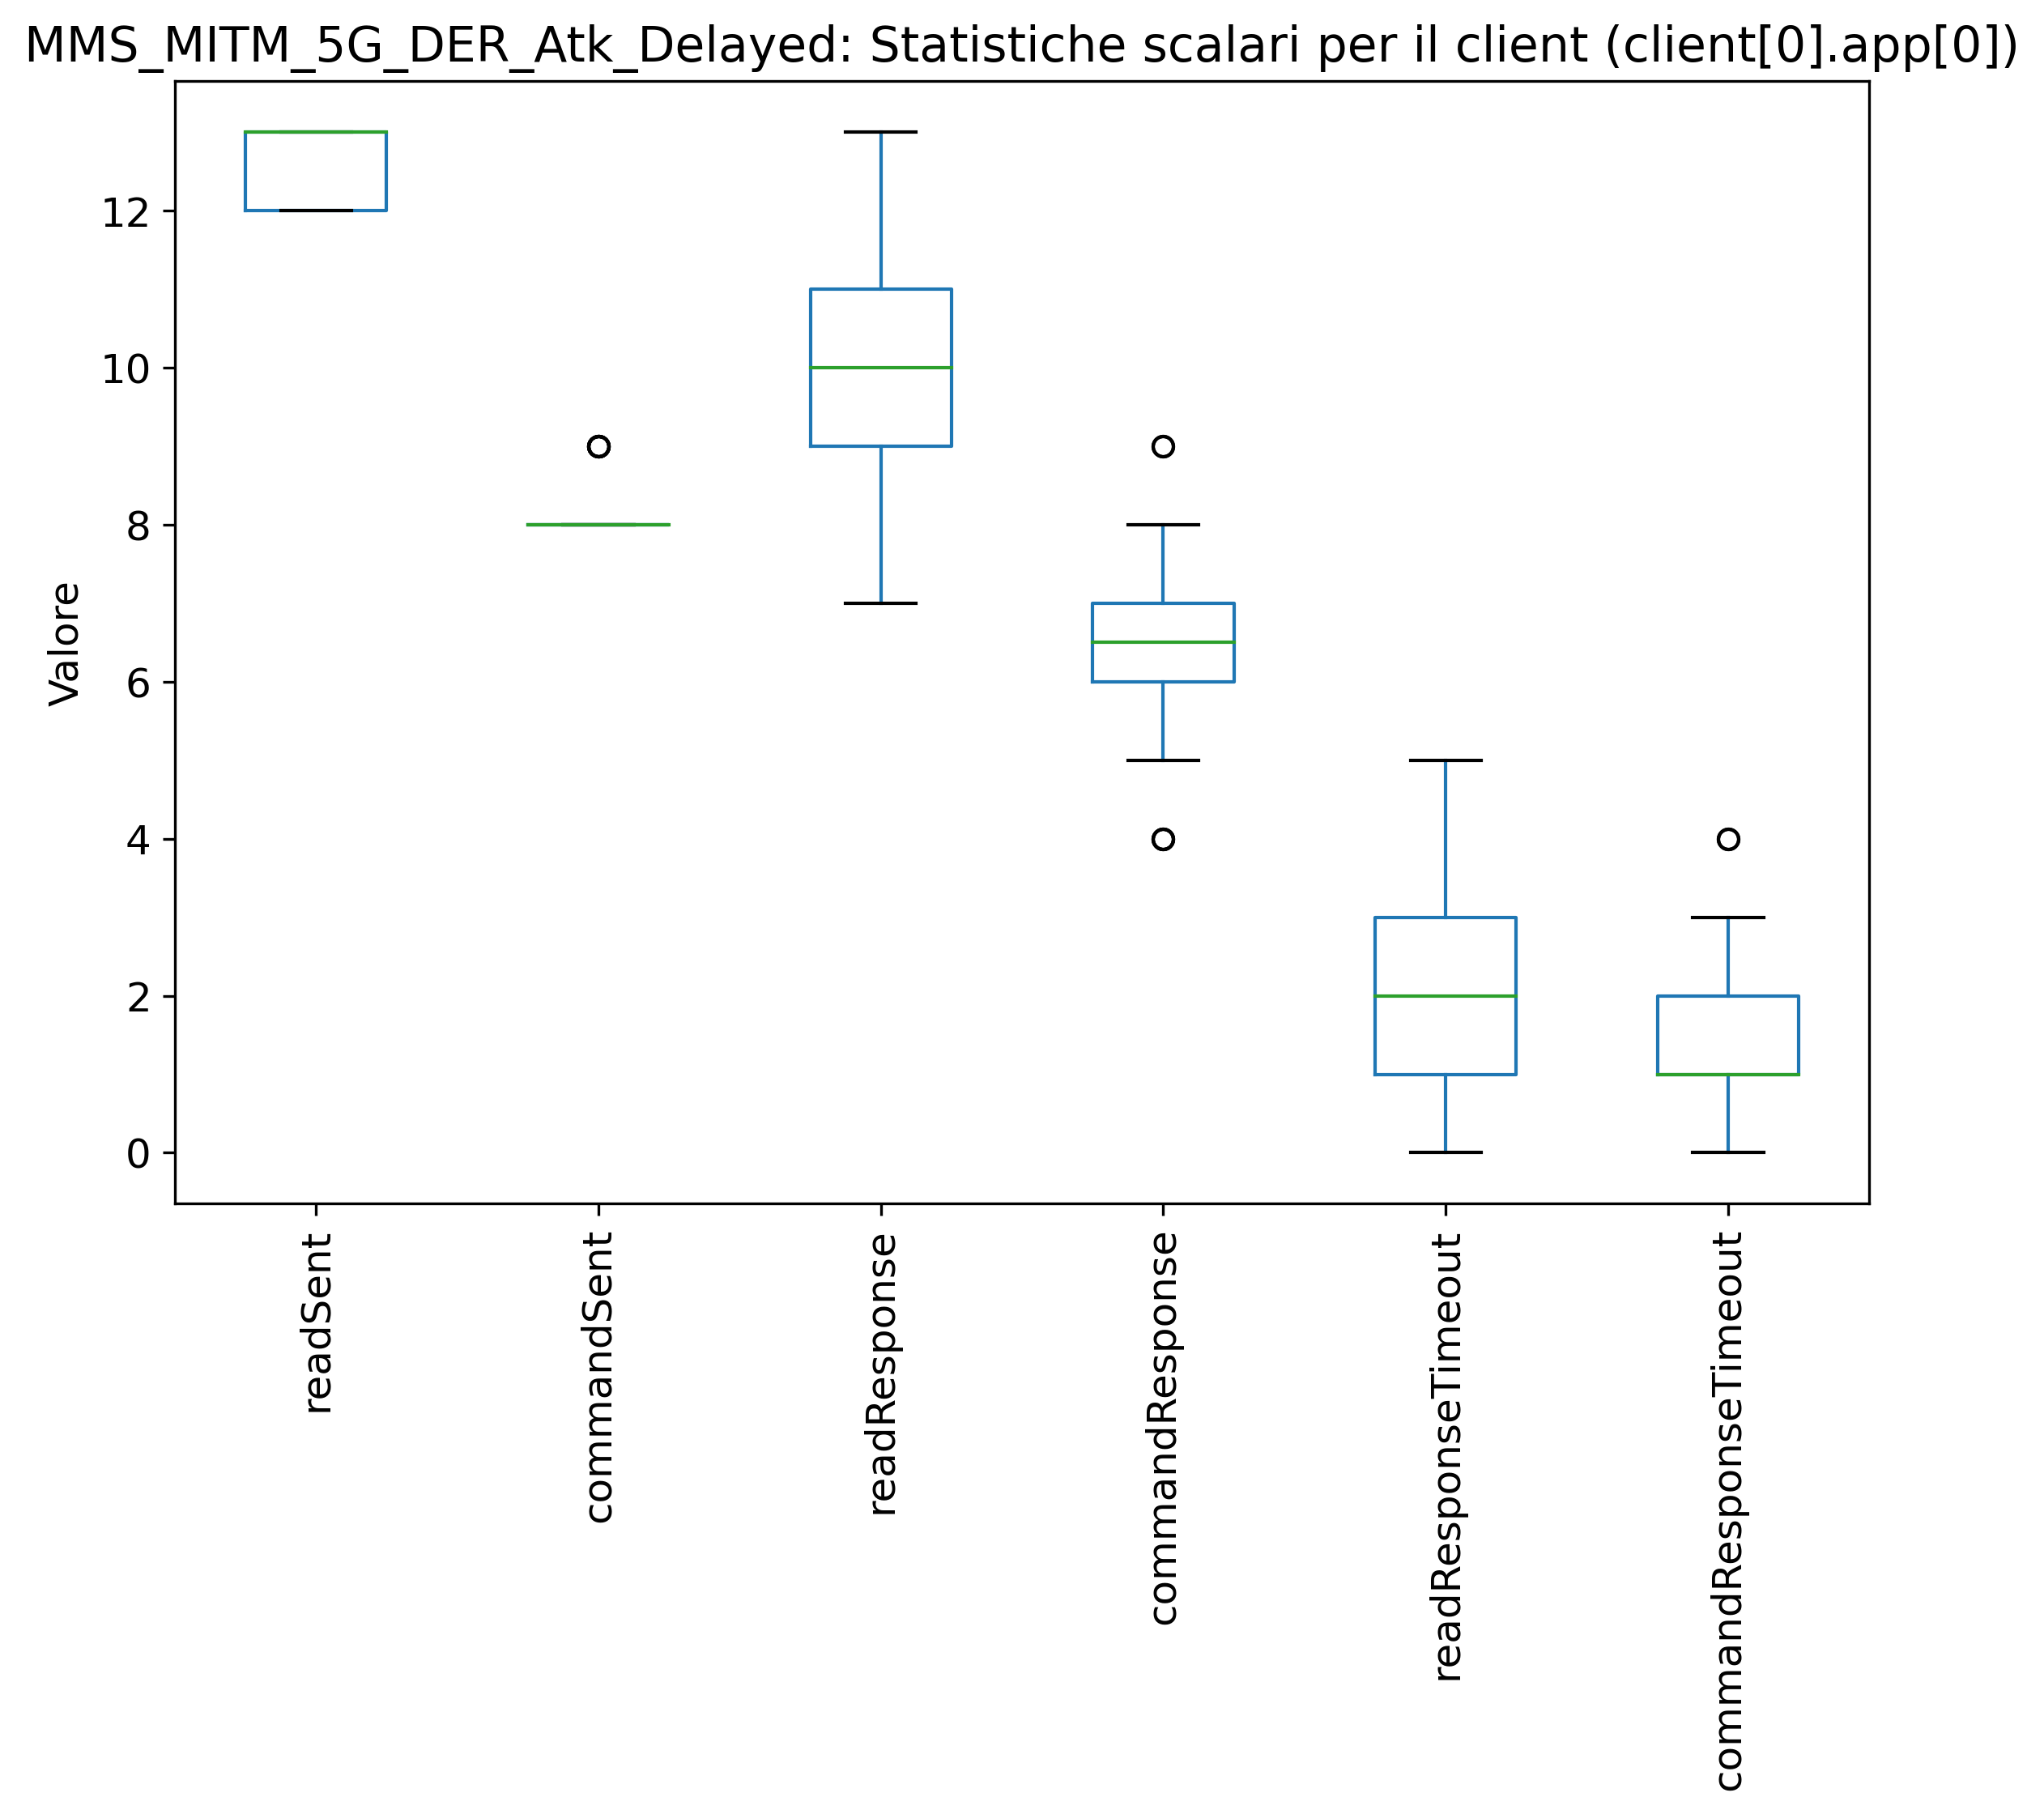

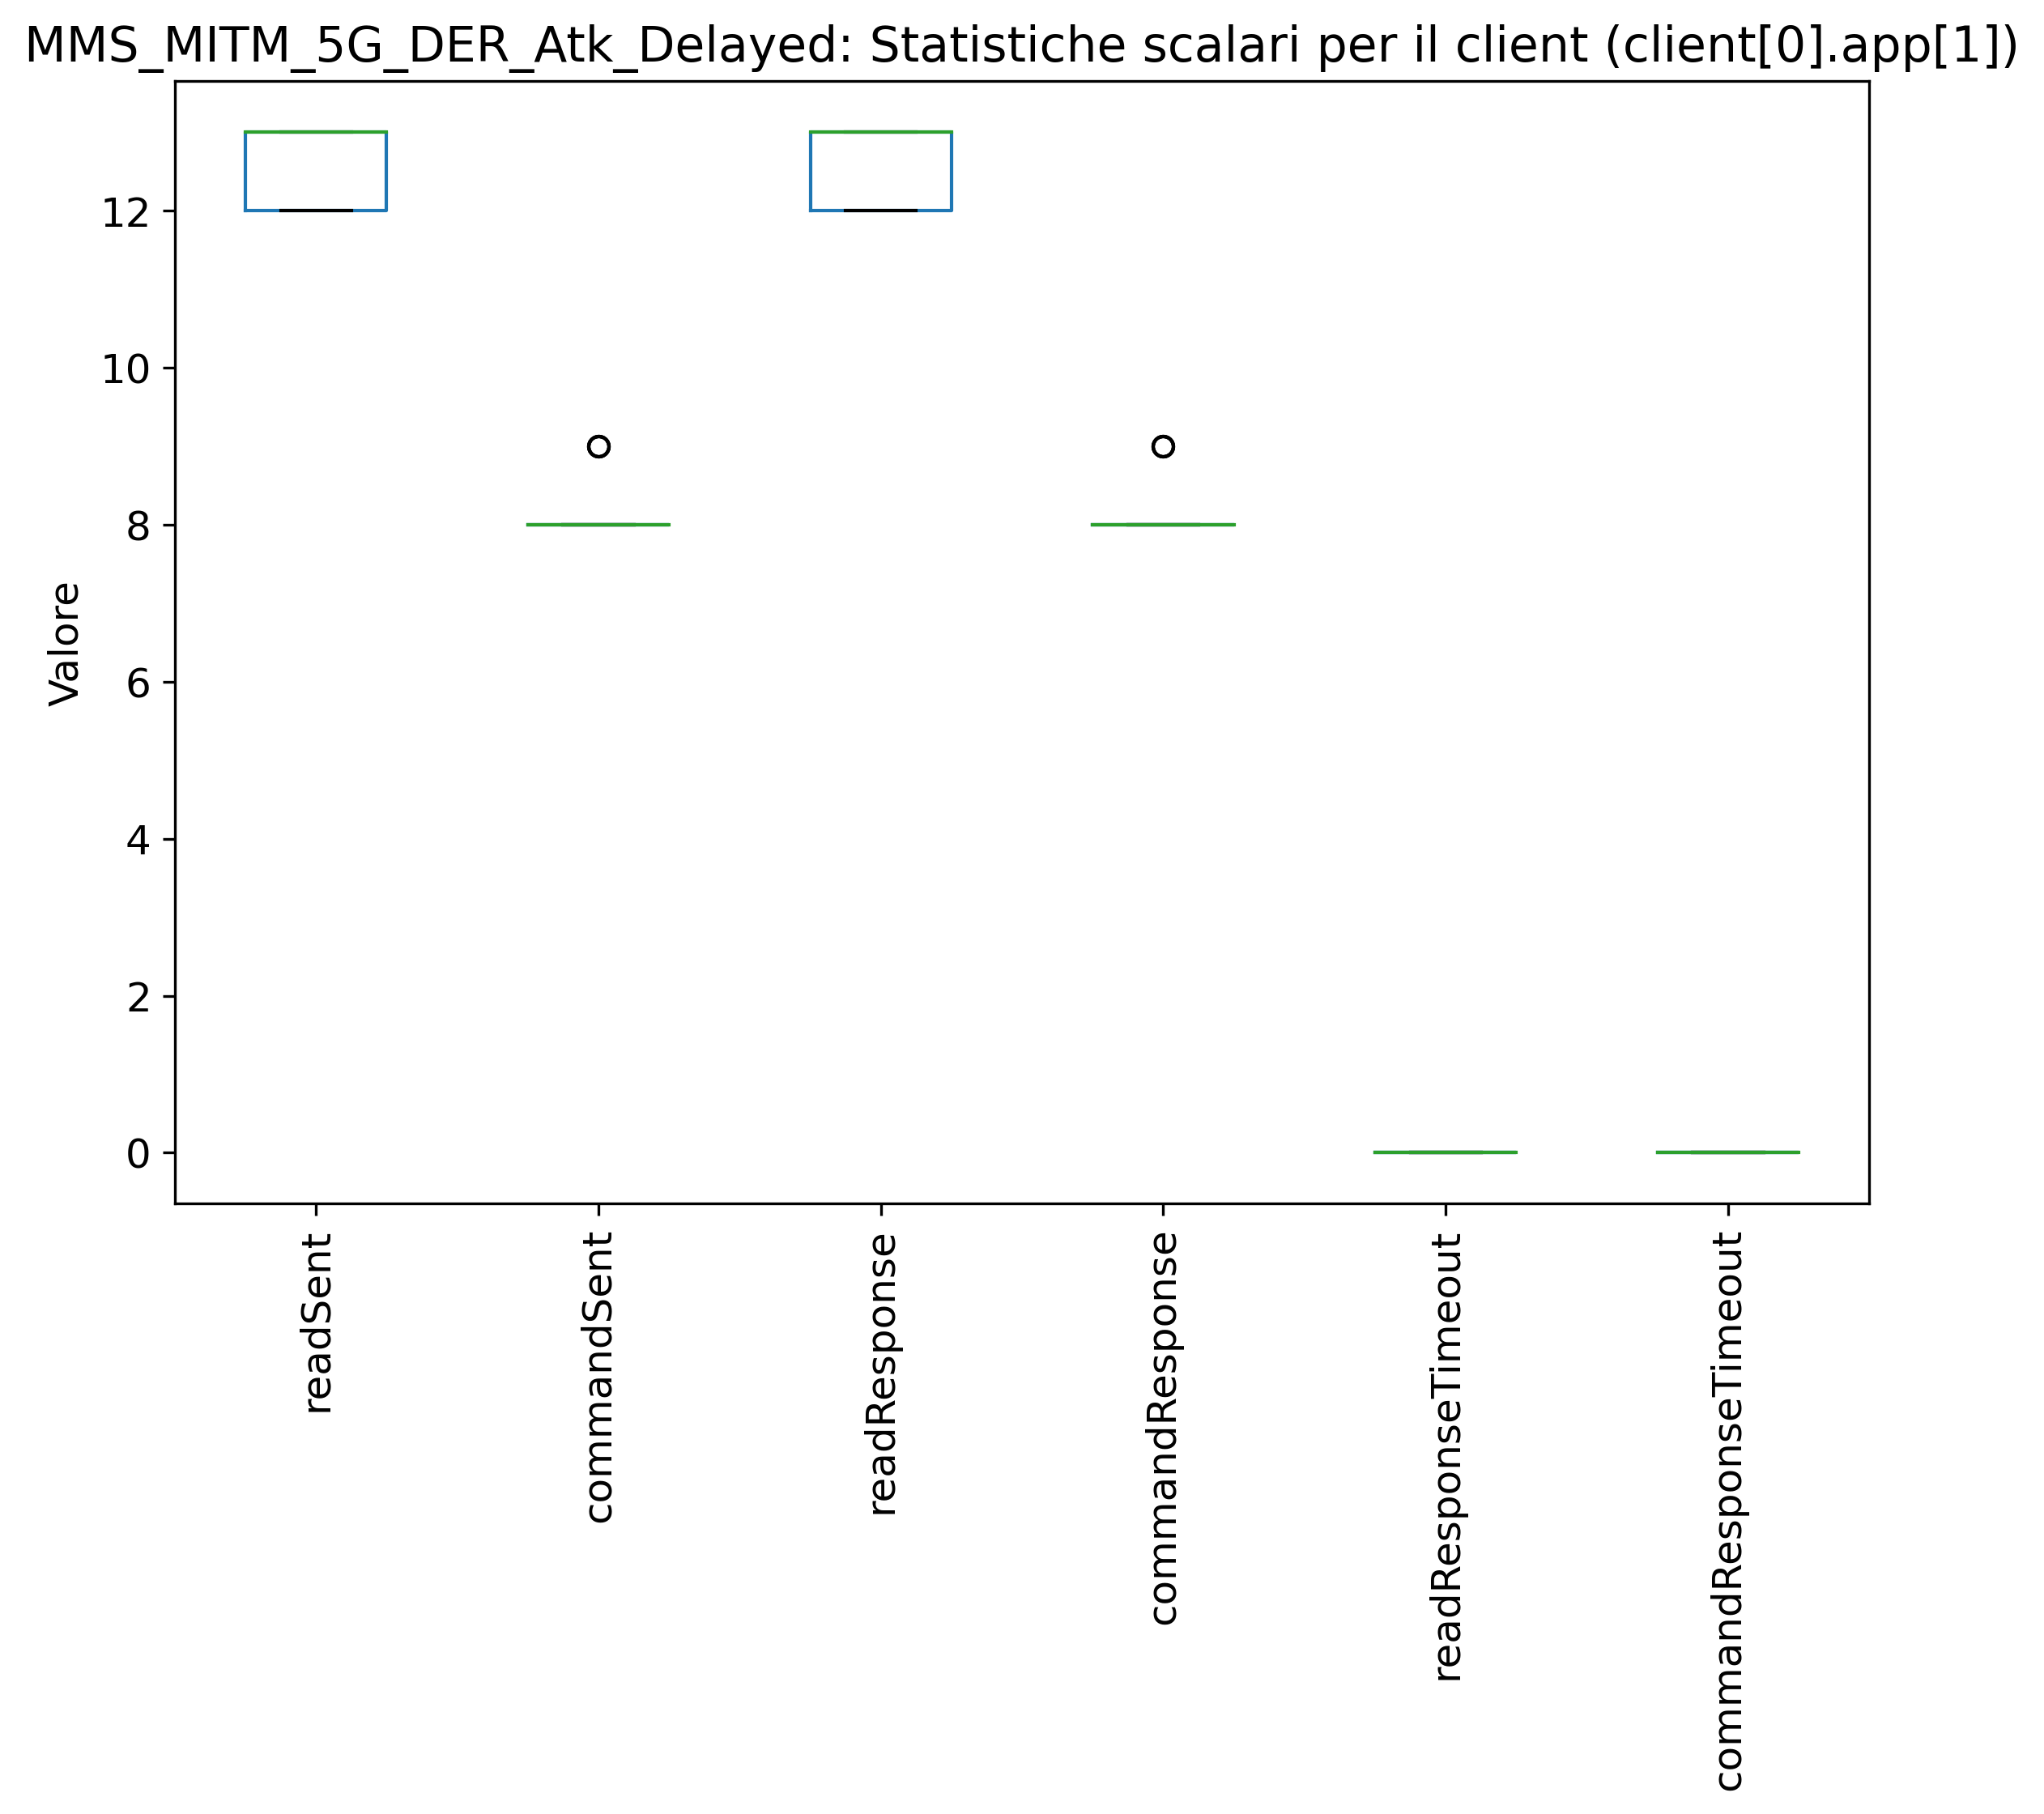

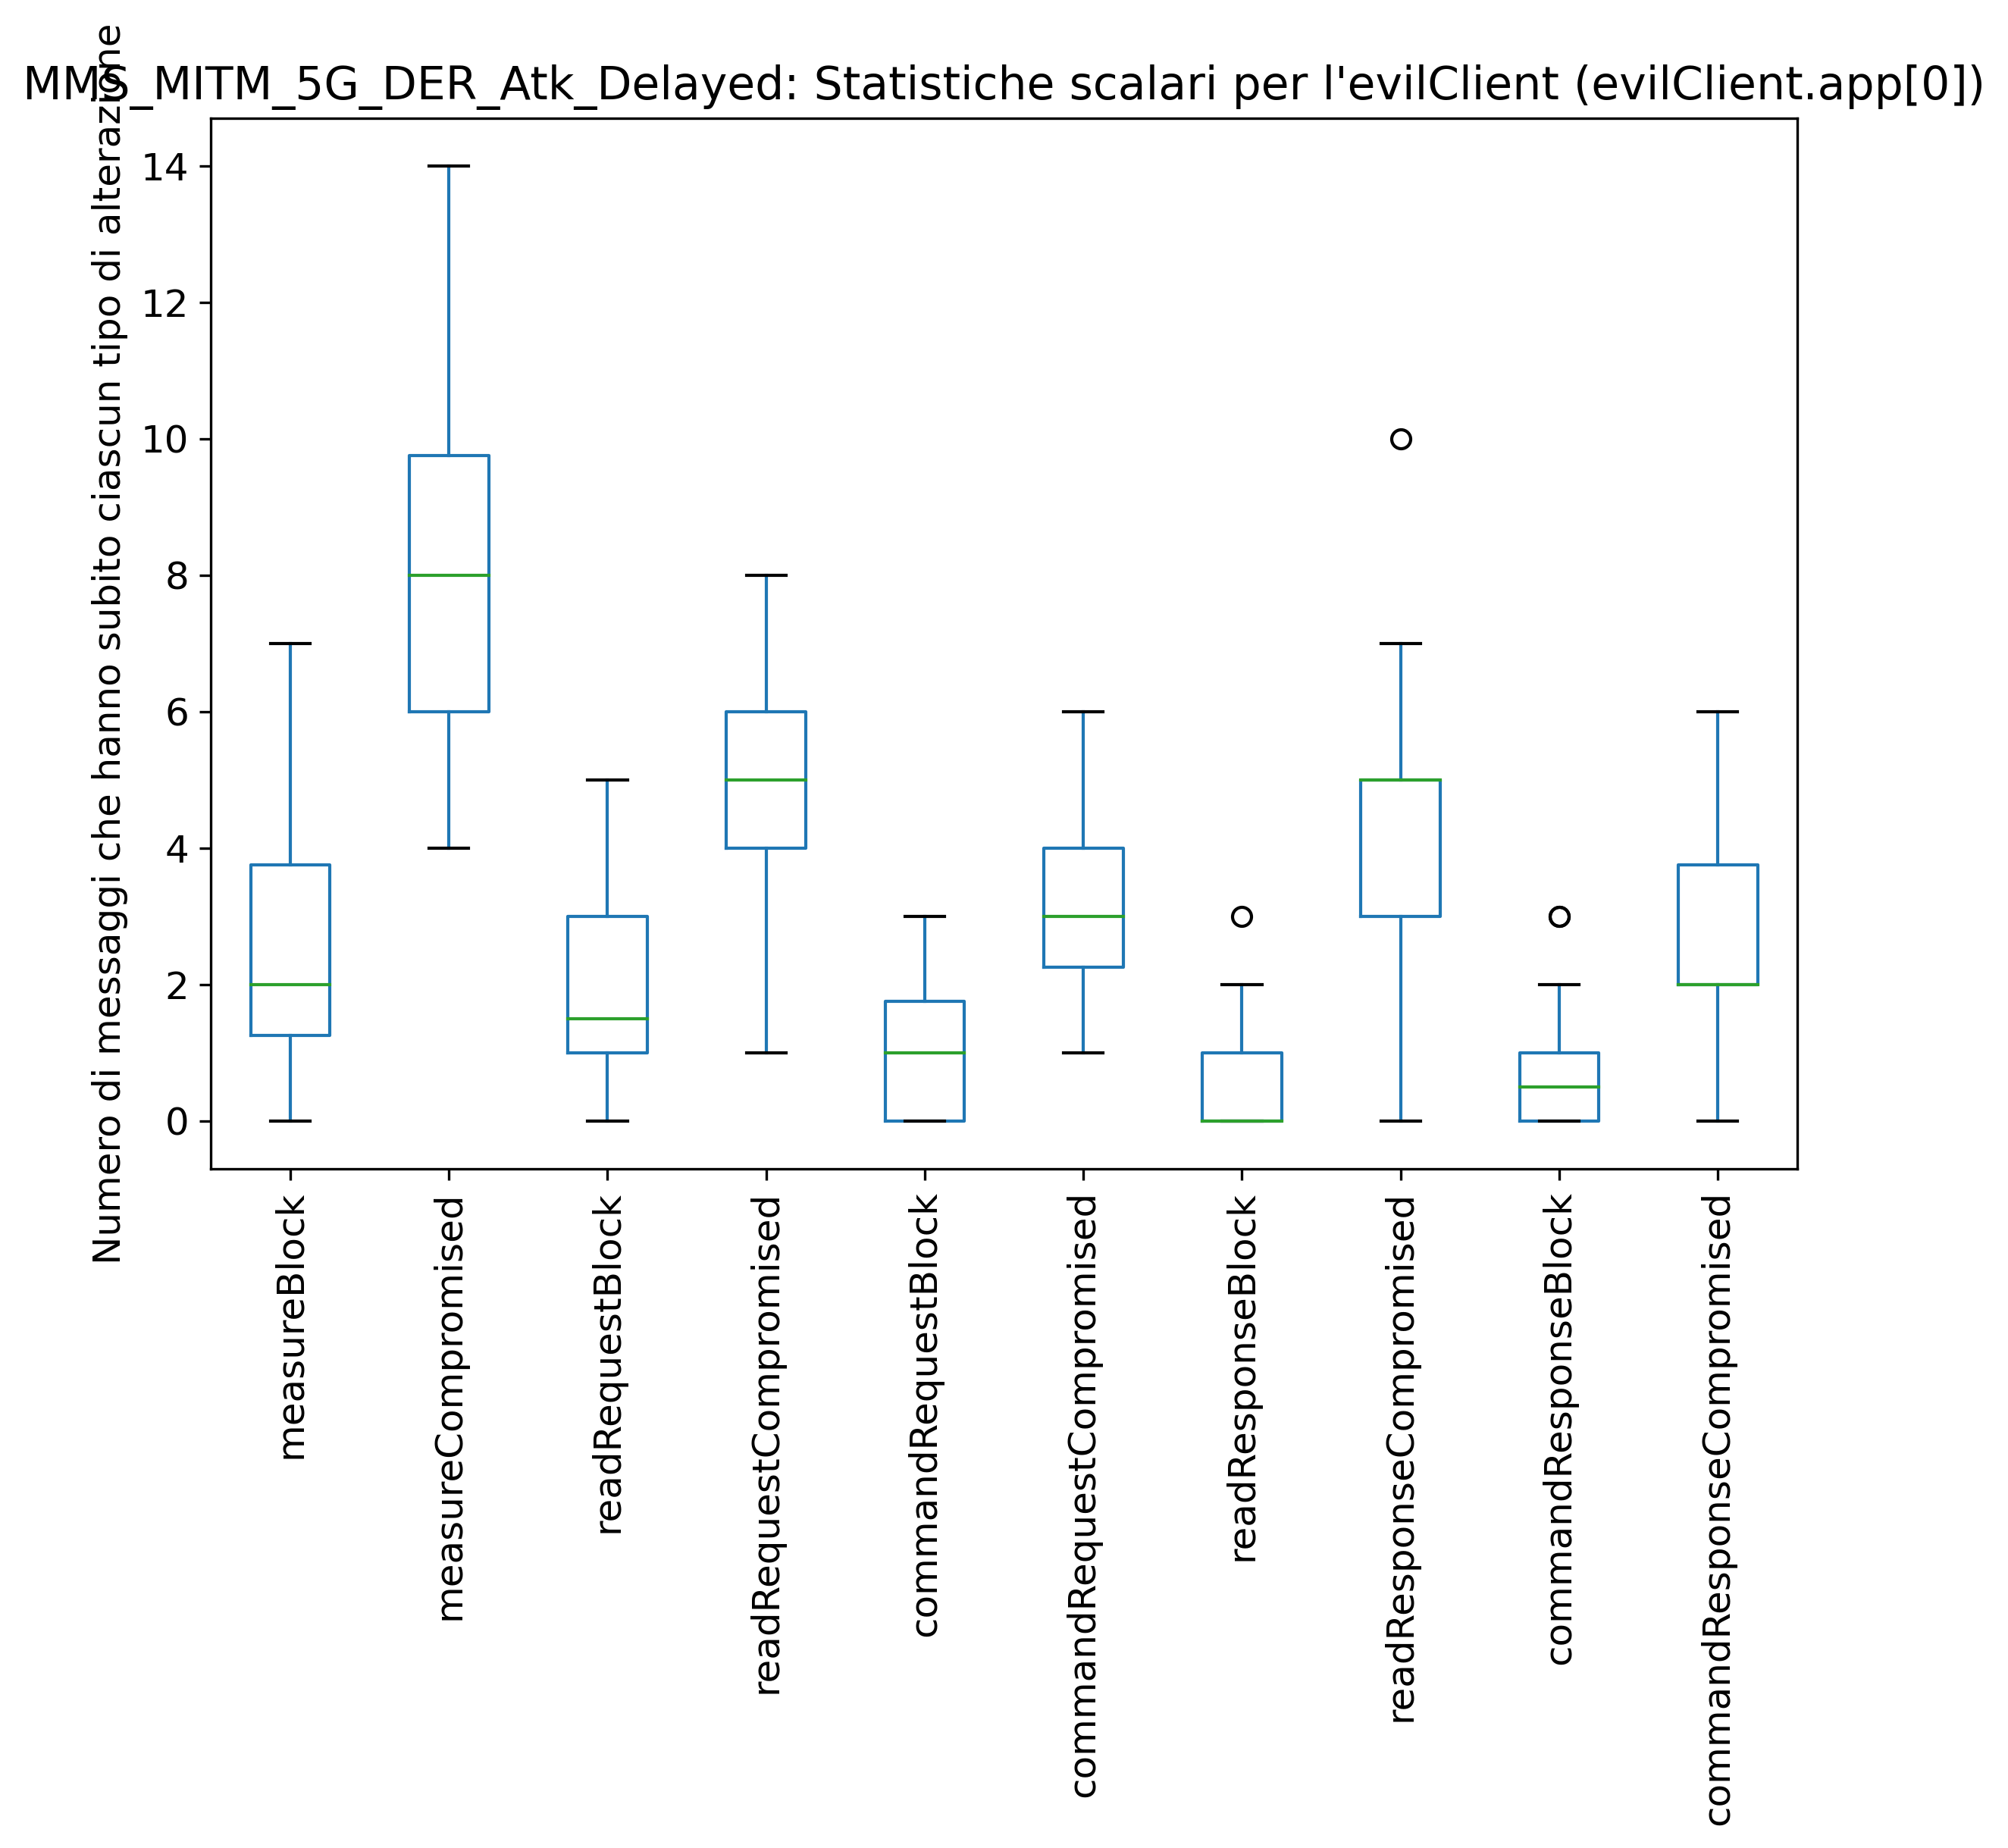

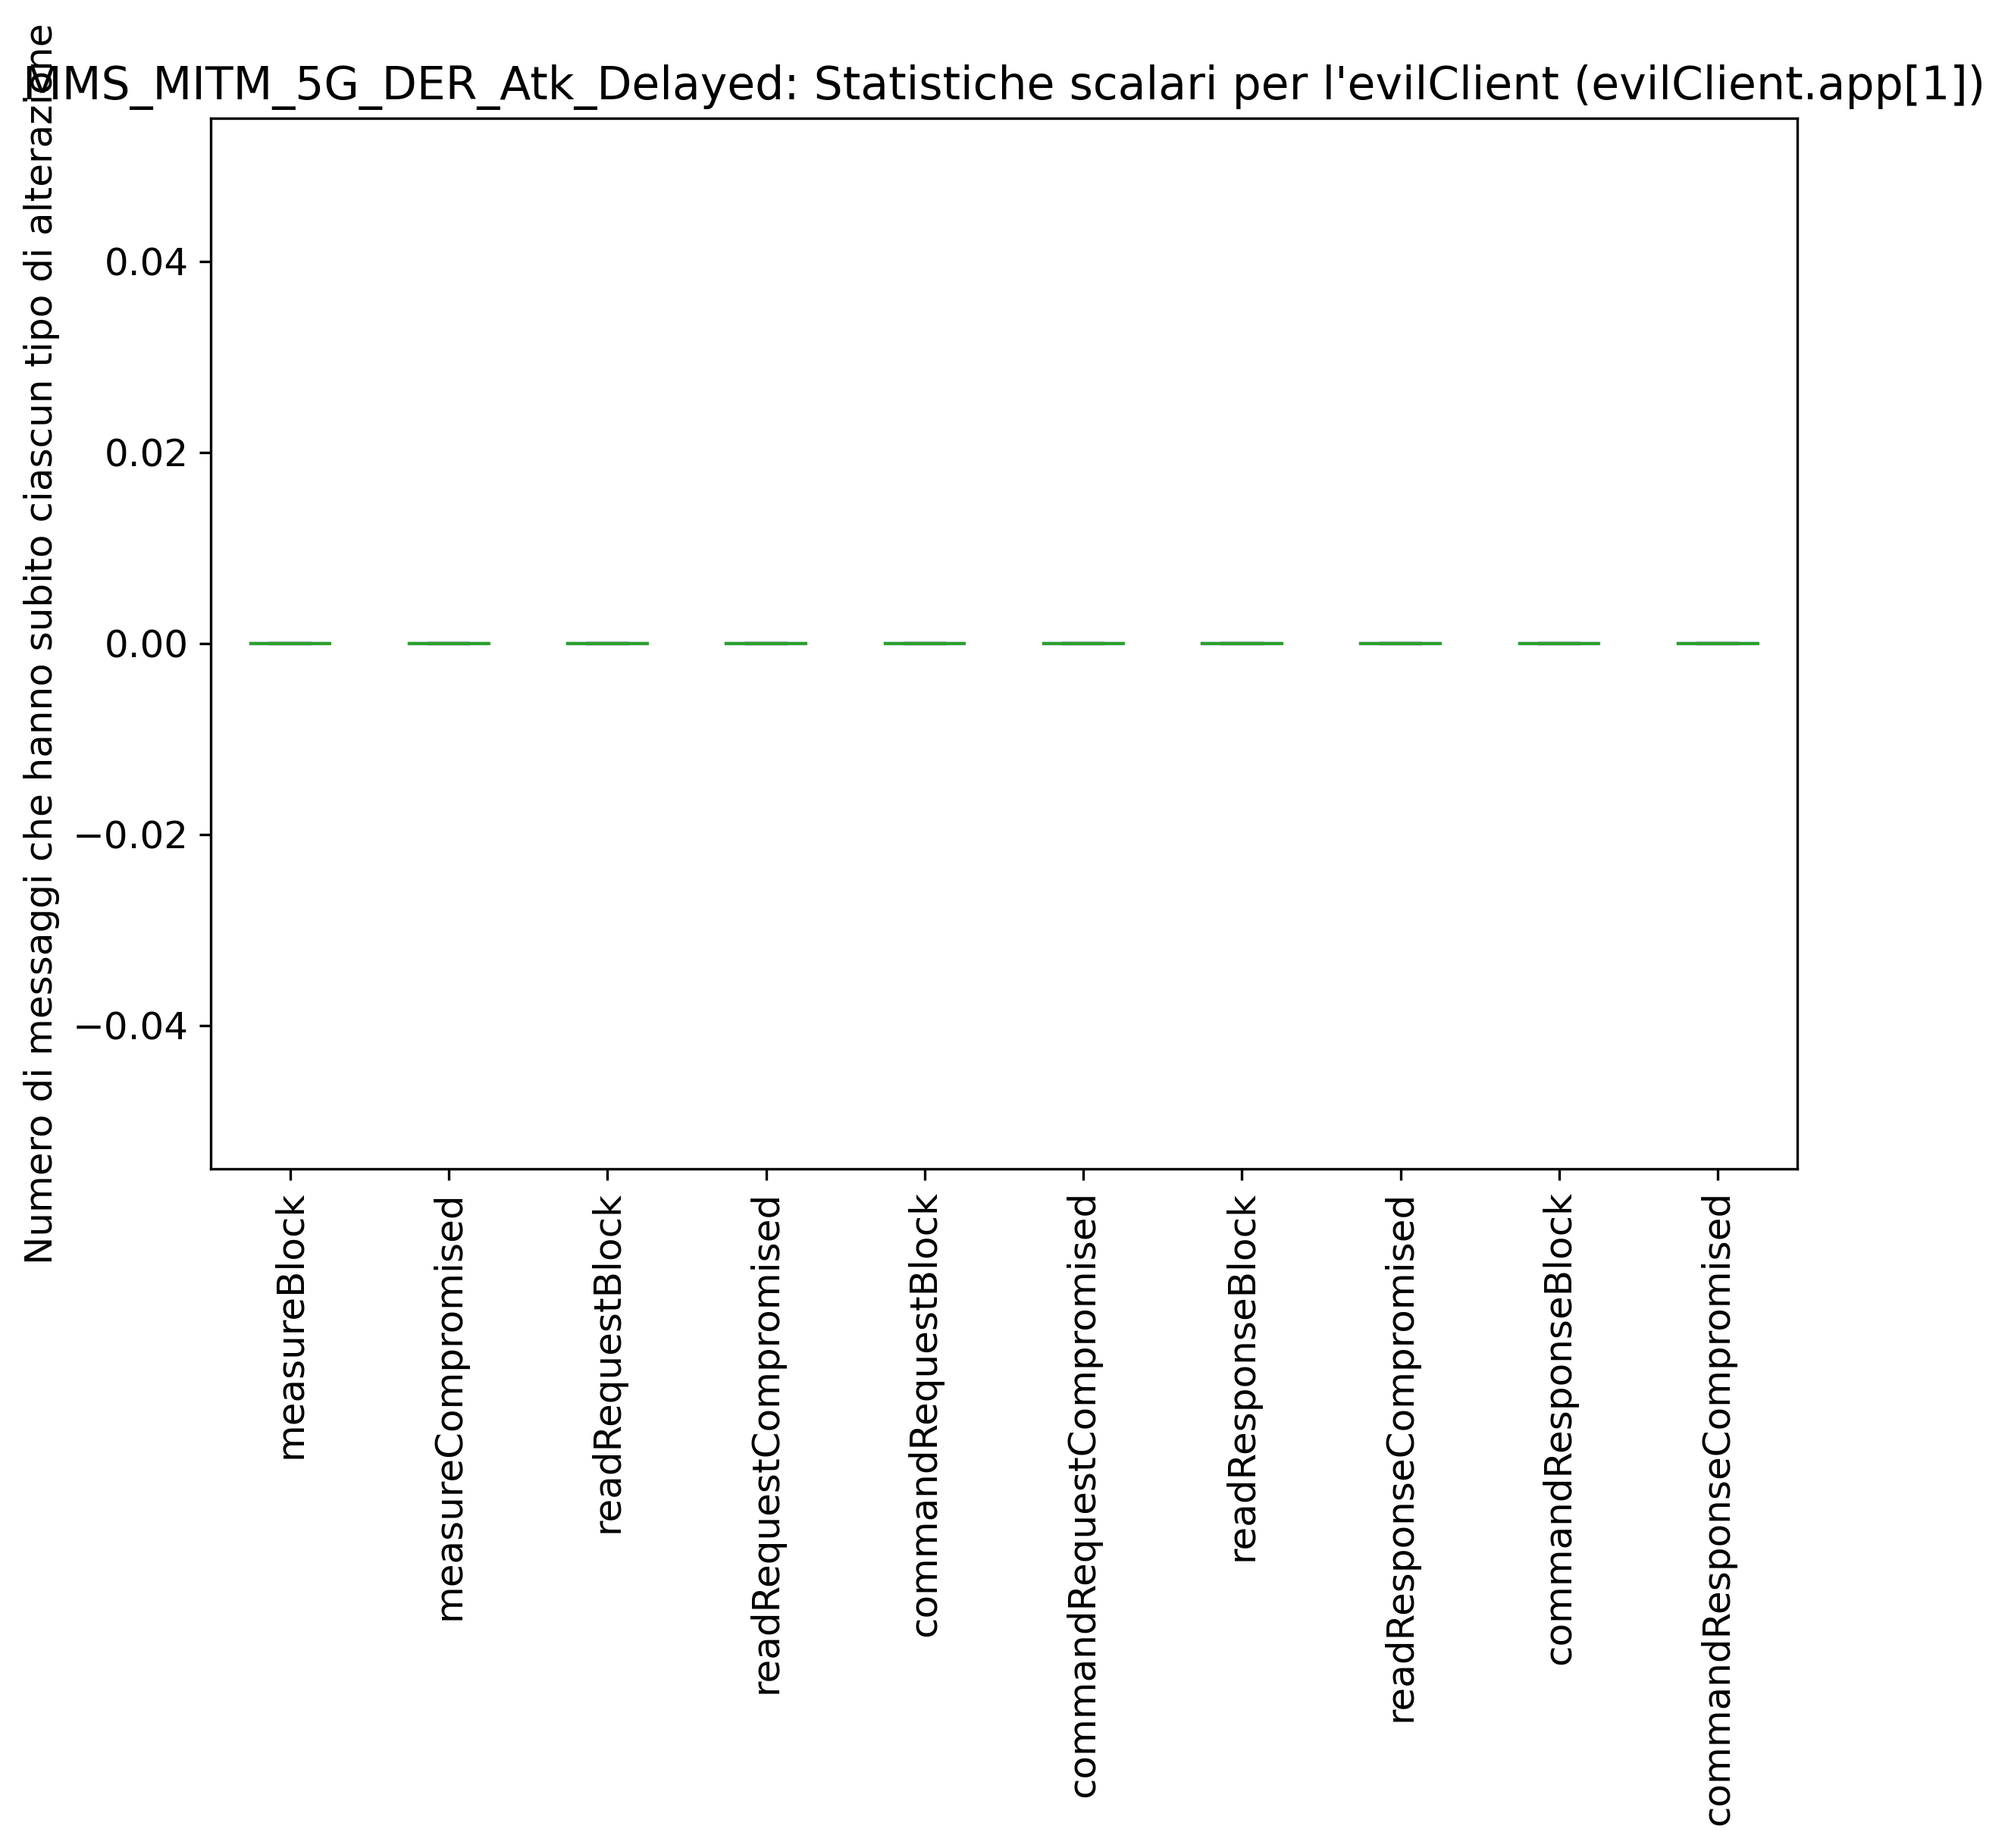

In [90]:
cliScaDfList = plotBoxWiskerSca(cliMeasNames, numClients, numServers, title=simName + ": Statistiche scalari per il client", yLab="Valore")
evilScaDfList = plotBoxWiskerSca(evilMeasNames, 1, numServers, cli="evilClient", title=simName + ": Statistiche scalari per l'evilClient", yLab="Numero di messaggi che hanno subito ciascun tipo di alterazione")

Scatter Matrices for clients

In [91]:
for i in range(numClients):
    for j in range(numServers):
        df = cliScaDfList[(i+1)*j]
        print("## Data description for client[" + str(i) + "].app[" + str(j) + "] ##")
        print(df.describe())
        print("## Correlation Matrix ##")
        print(df.corr())
        #pd.plotting.scatter_matrix(df, figsize=(22,22))
        #plt.suptitle("Scatter Matrix for client[" + str(i) + "].app[" + str(j) + "]")


## Data description for client[0].app[0] ##
        readSent  commandSent  readResponse  commandResponse  \
count  30.000000    30.000000     30.000000        30.000000   
mean   12.633333     8.166667     10.033333         6.466667   
std     0.490133     0.379049      1.586219         1.382984   
min    12.000000     8.000000      7.000000         4.000000   
25%    12.000000     8.000000      9.000000         6.000000   
50%    13.000000     8.000000     10.000000         6.500000   
75%    13.000000     8.000000     11.000000         7.000000   
max    13.000000     9.000000     13.000000         9.000000   

       readResponseTimeout  commandResponseTimeout  
count            30.000000               30.000000  
mean              2.200000                1.533333  
std               1.270352                1.195778  
min               0.000000                0.000000  
25%               1.000000                1.000000  
50%               2.000000                1.000000  
75%     

Scatter matrix for the evilClient

In [92]:
if not isDos:
    for j in range(numServers):
        df = evilScaDfList[j]
        print("## Data description for evilClient.app[" + str(j) + "] ##")
        print(df.describe())
        print("## Correlation Matrix ##")
        print(df.corr())
        #pd.plotting.scatter_matrix(df, figsize=(25,25))
        #plt.suptitle("Scatter Matrix for evilClient.app[" + str(j) + "]")

[(0, 15.0), (15.0, 30.0), (30.0, 45.0), (45.0, 60.0), (60.0, 75.0), (75.0, 90.0), (90.0, 105.0), (105.0, 120.0)]


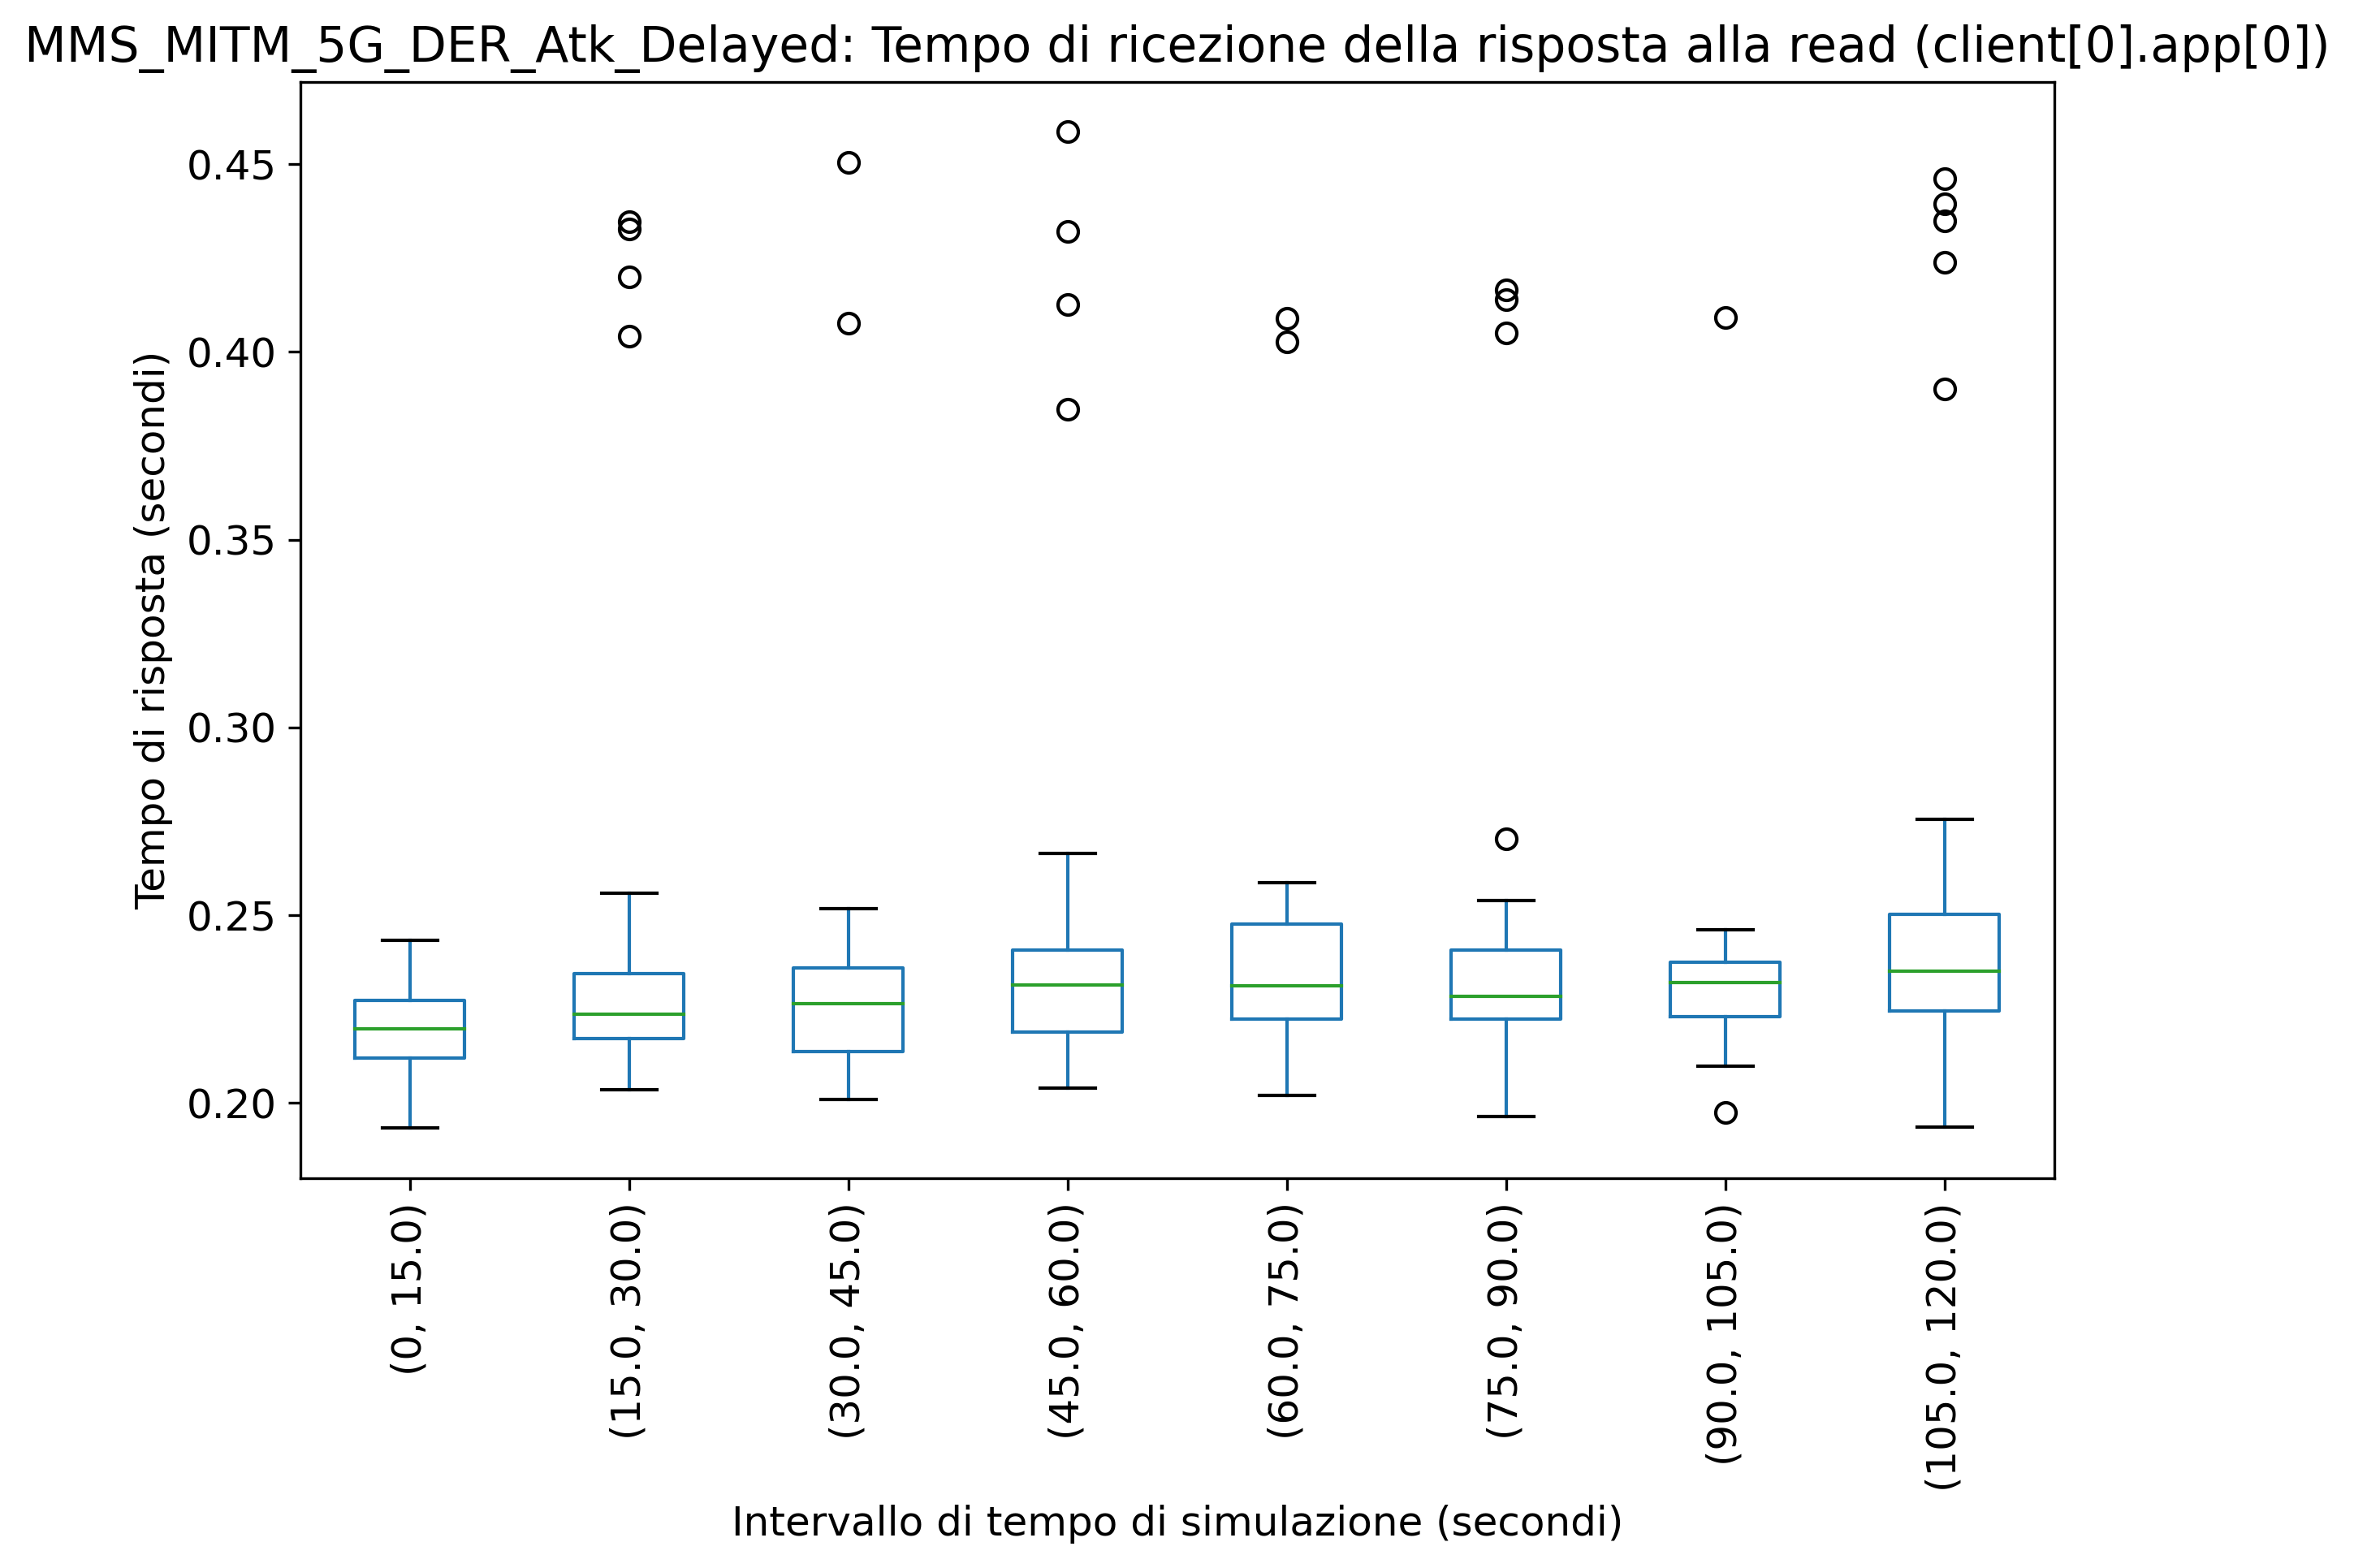

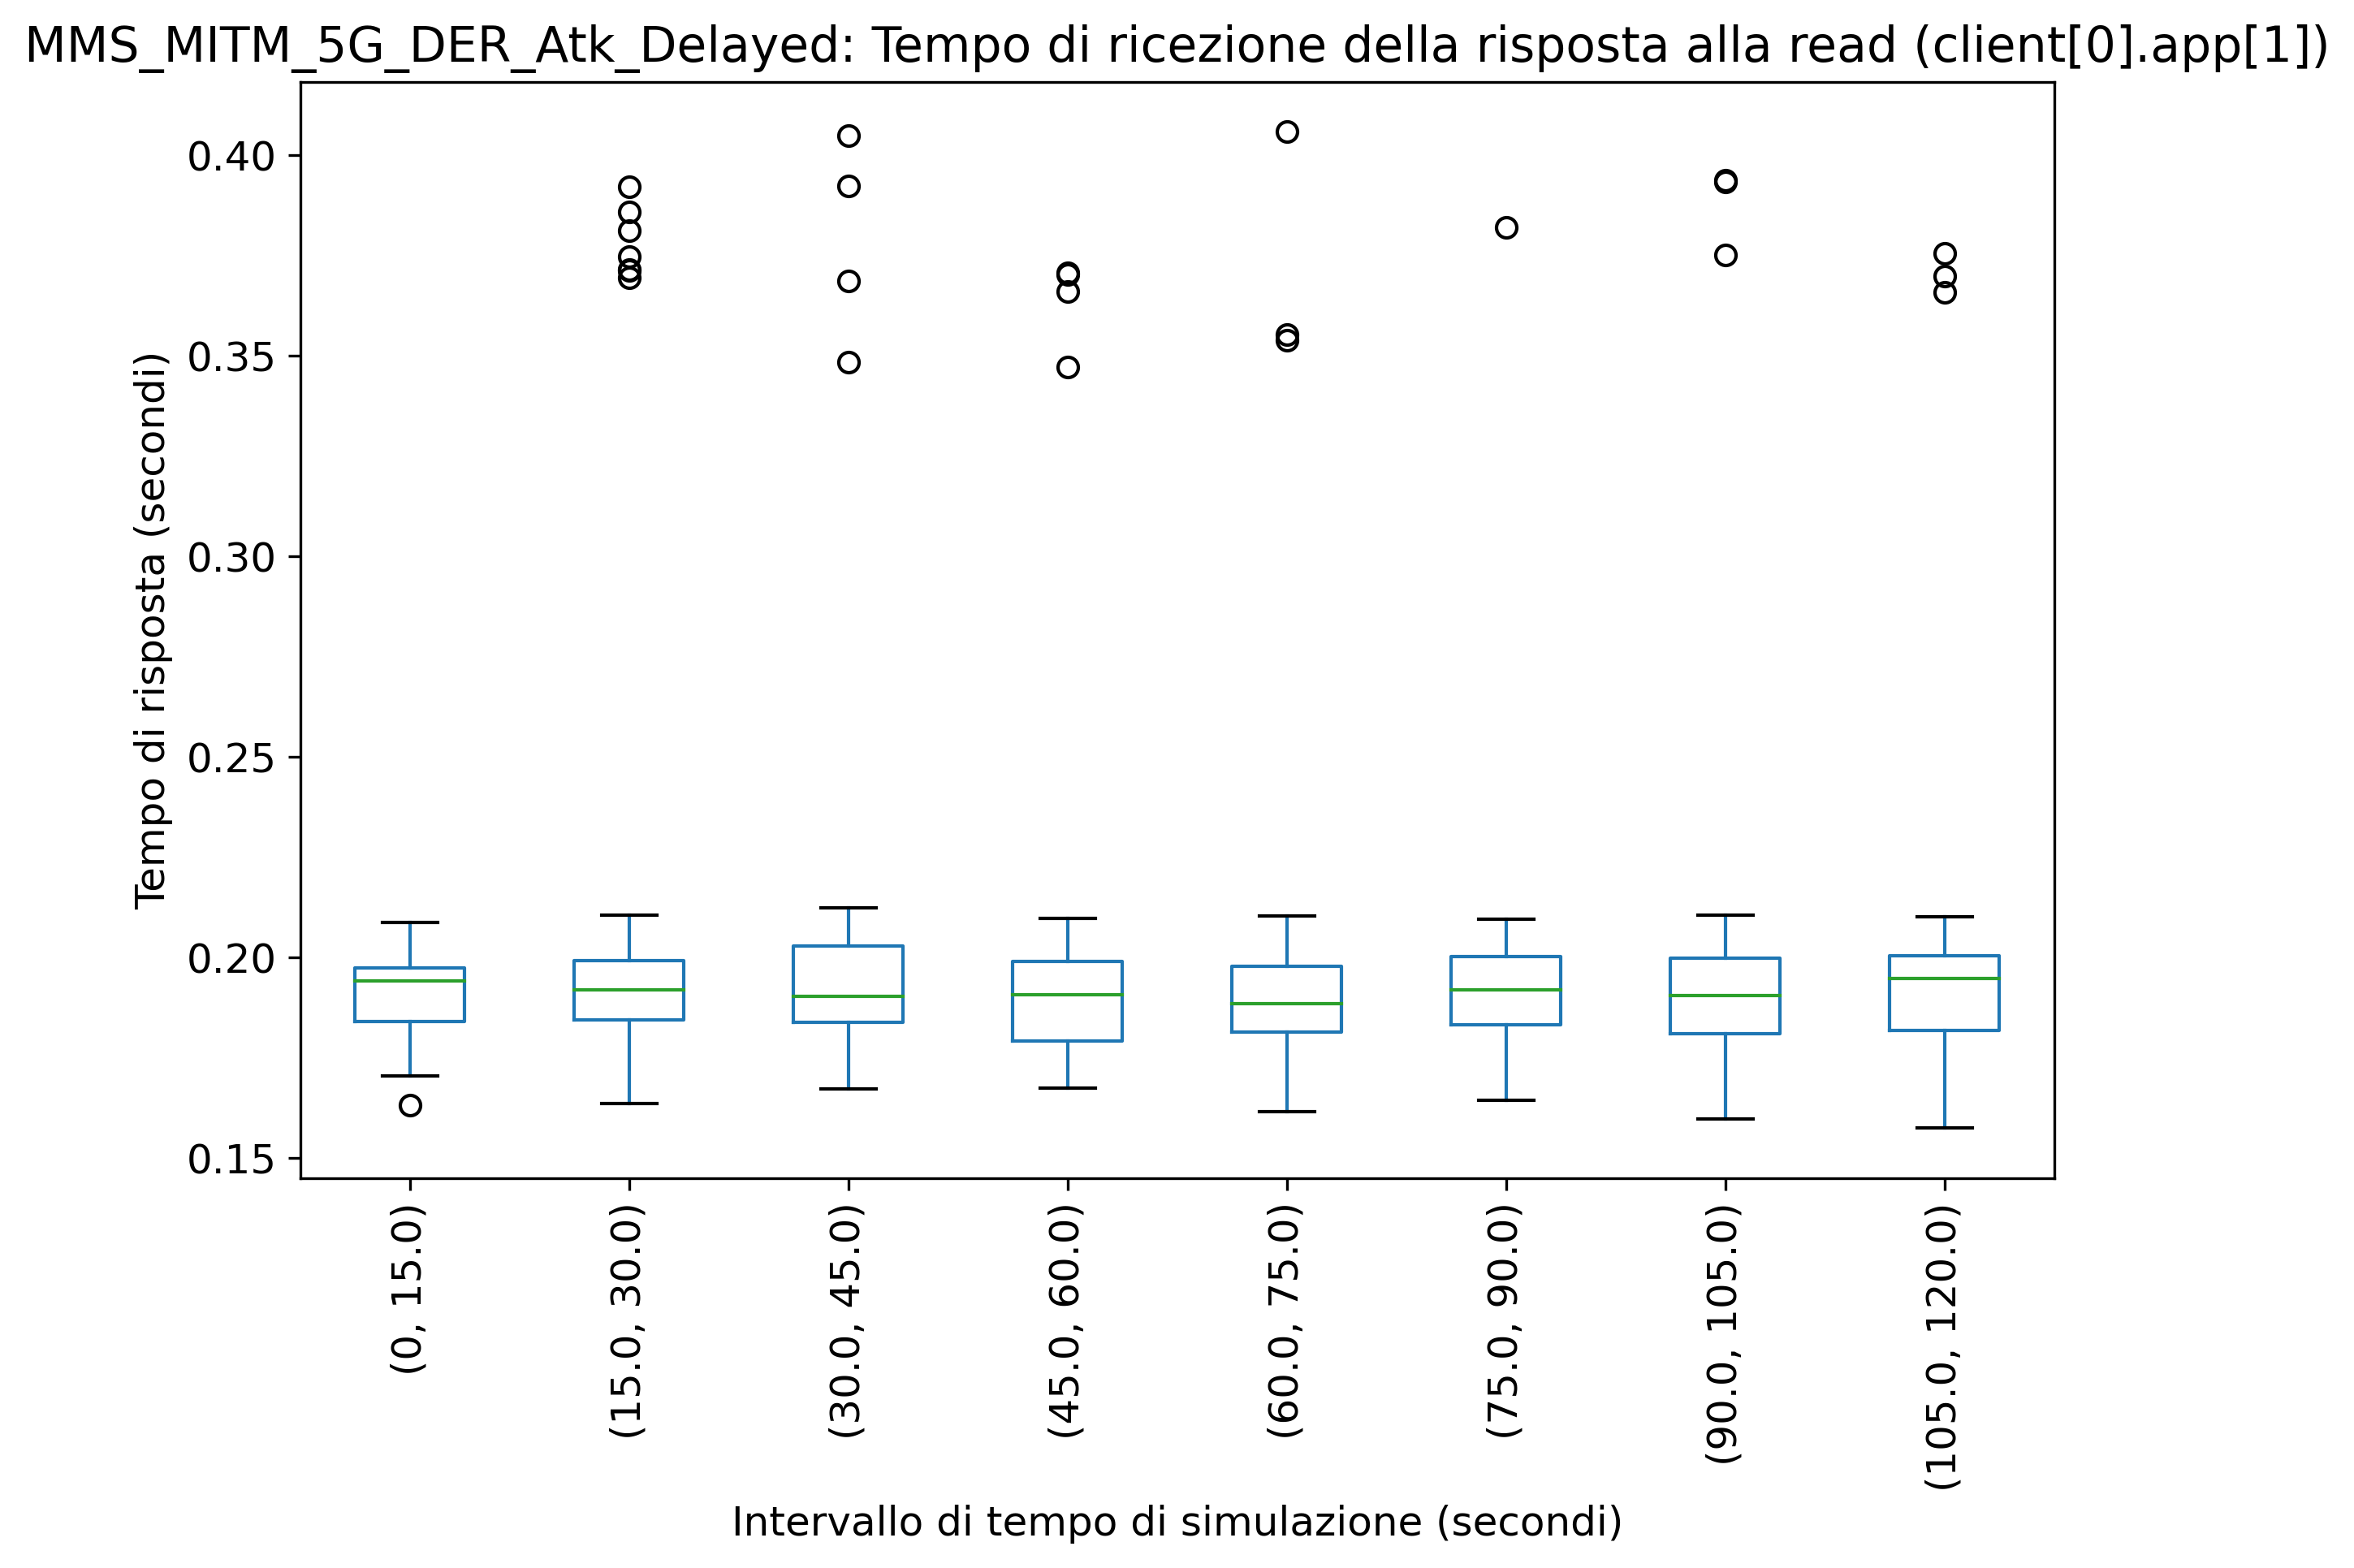

[(0, 20.0), (20.0, 40.0), (40.0, 60.0), (60.0, 80.0), (80.0, 100.0), (100.0, 120.0)]


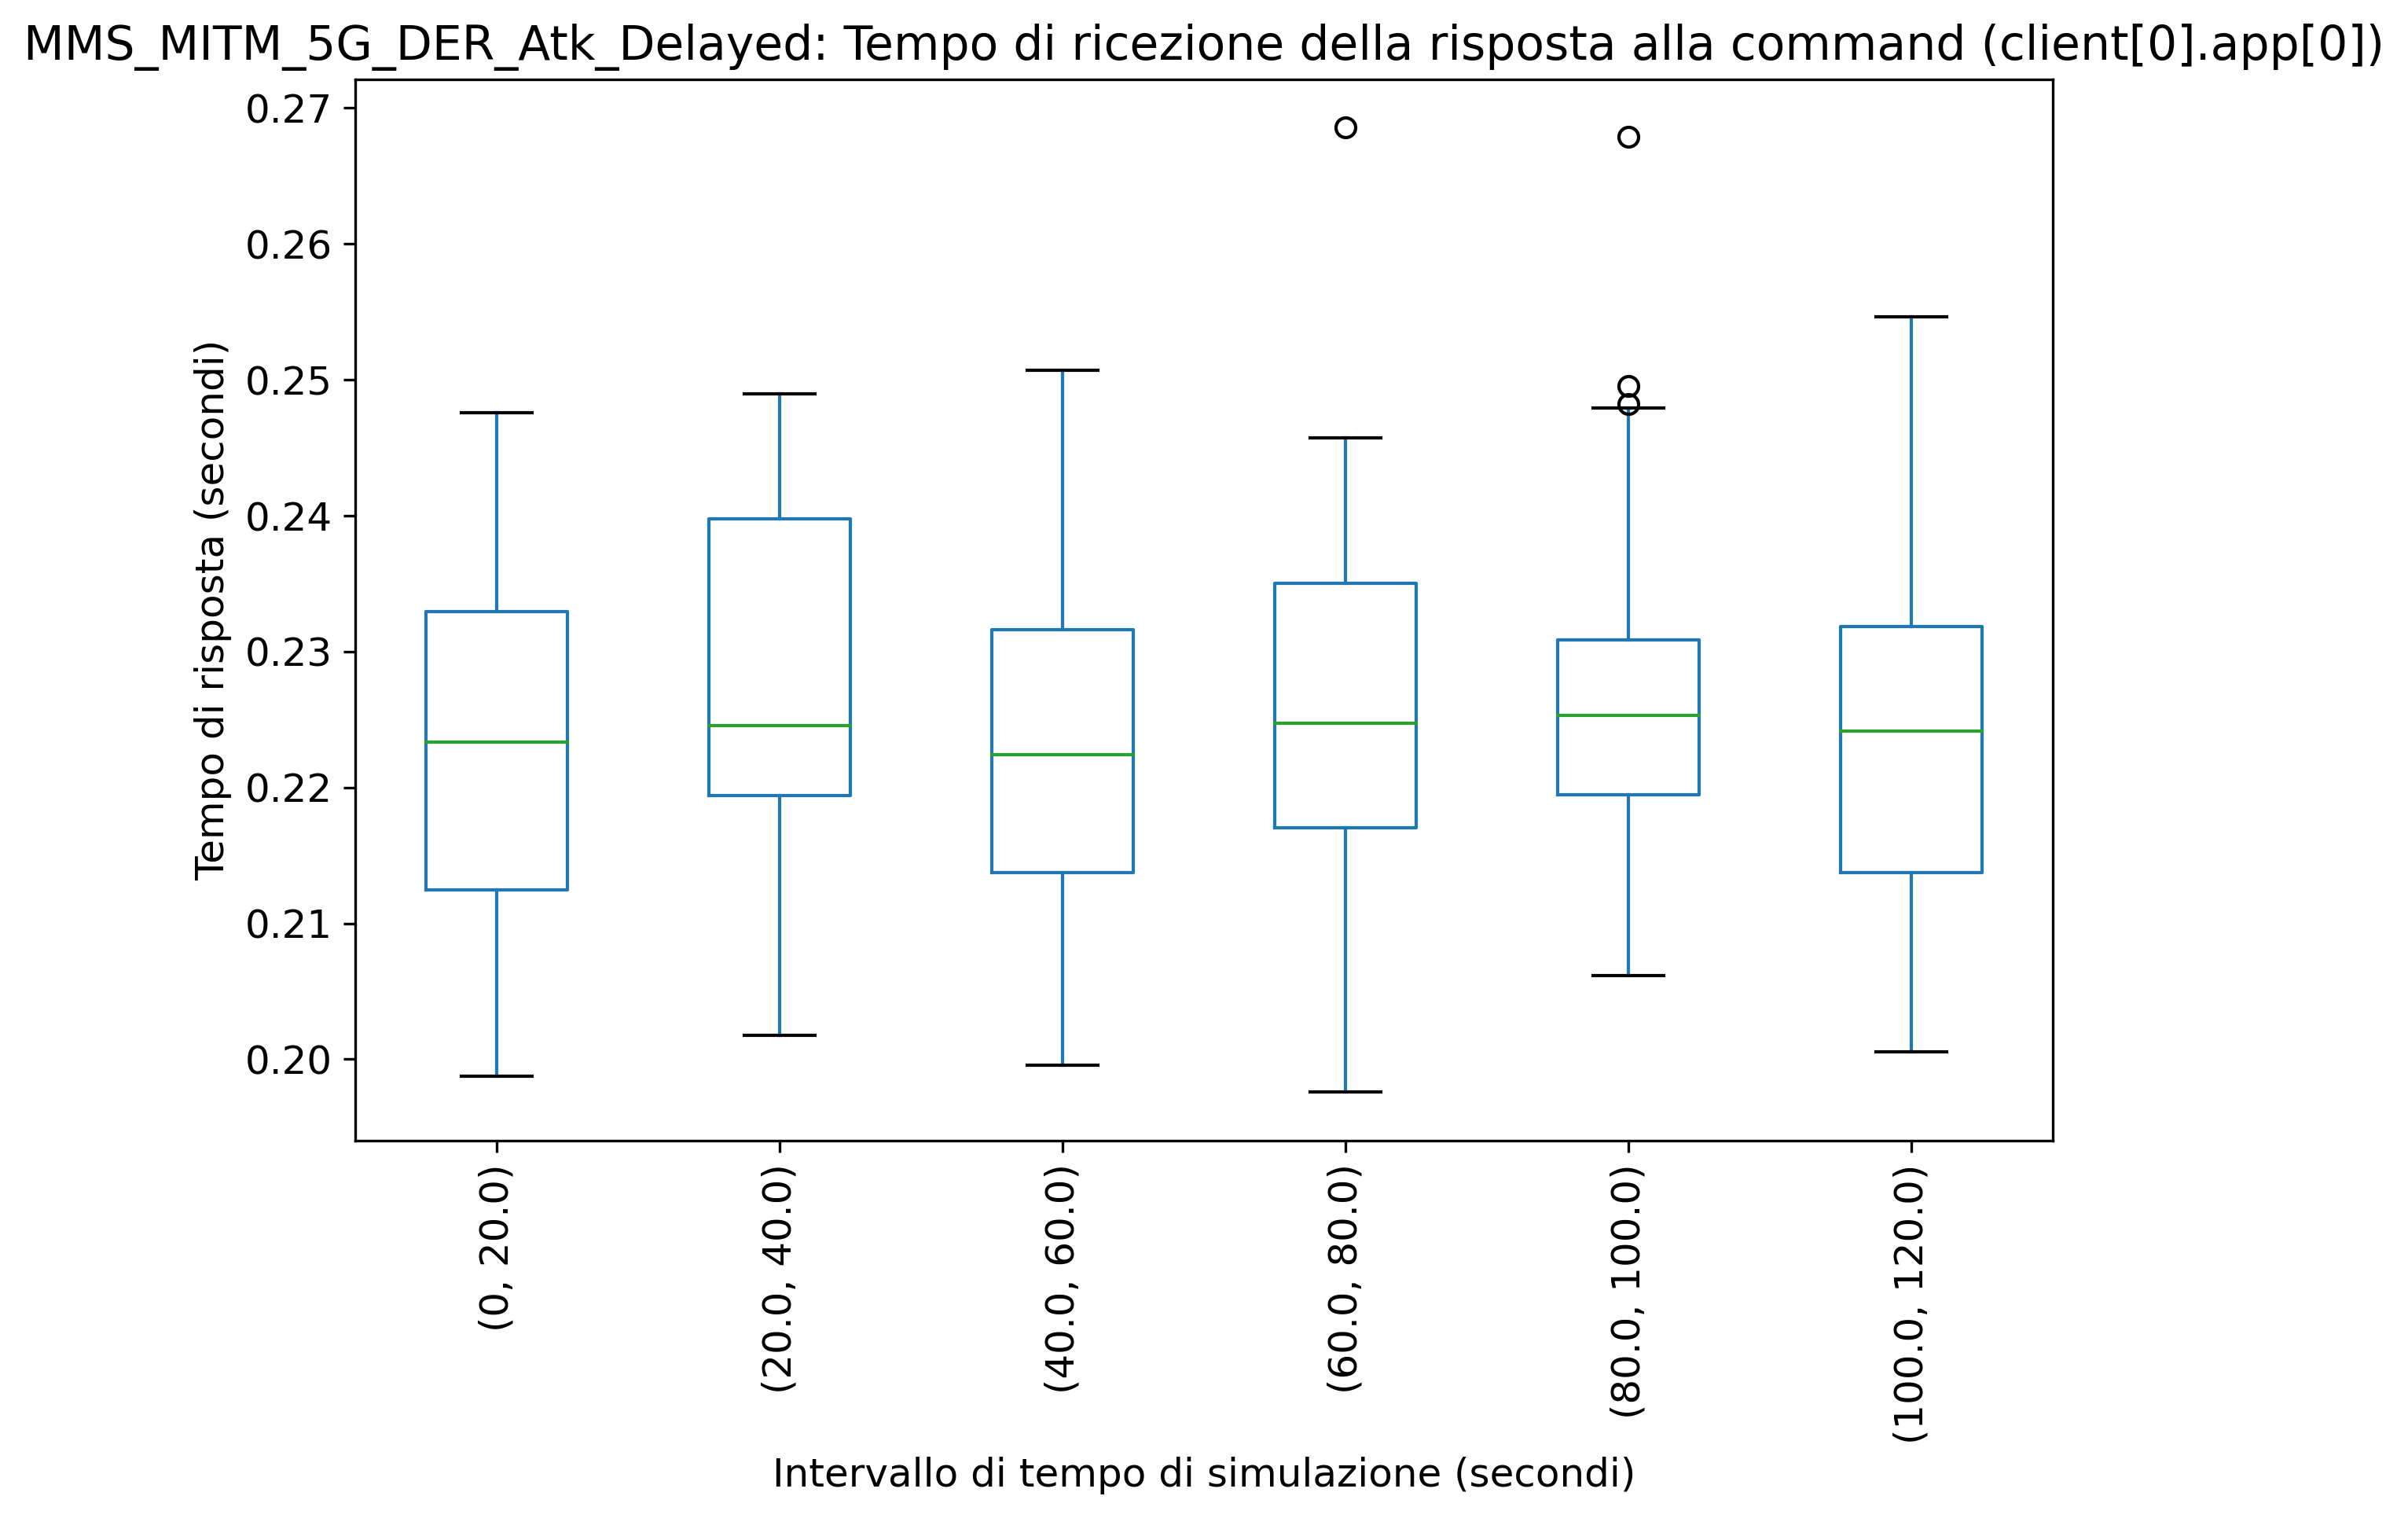

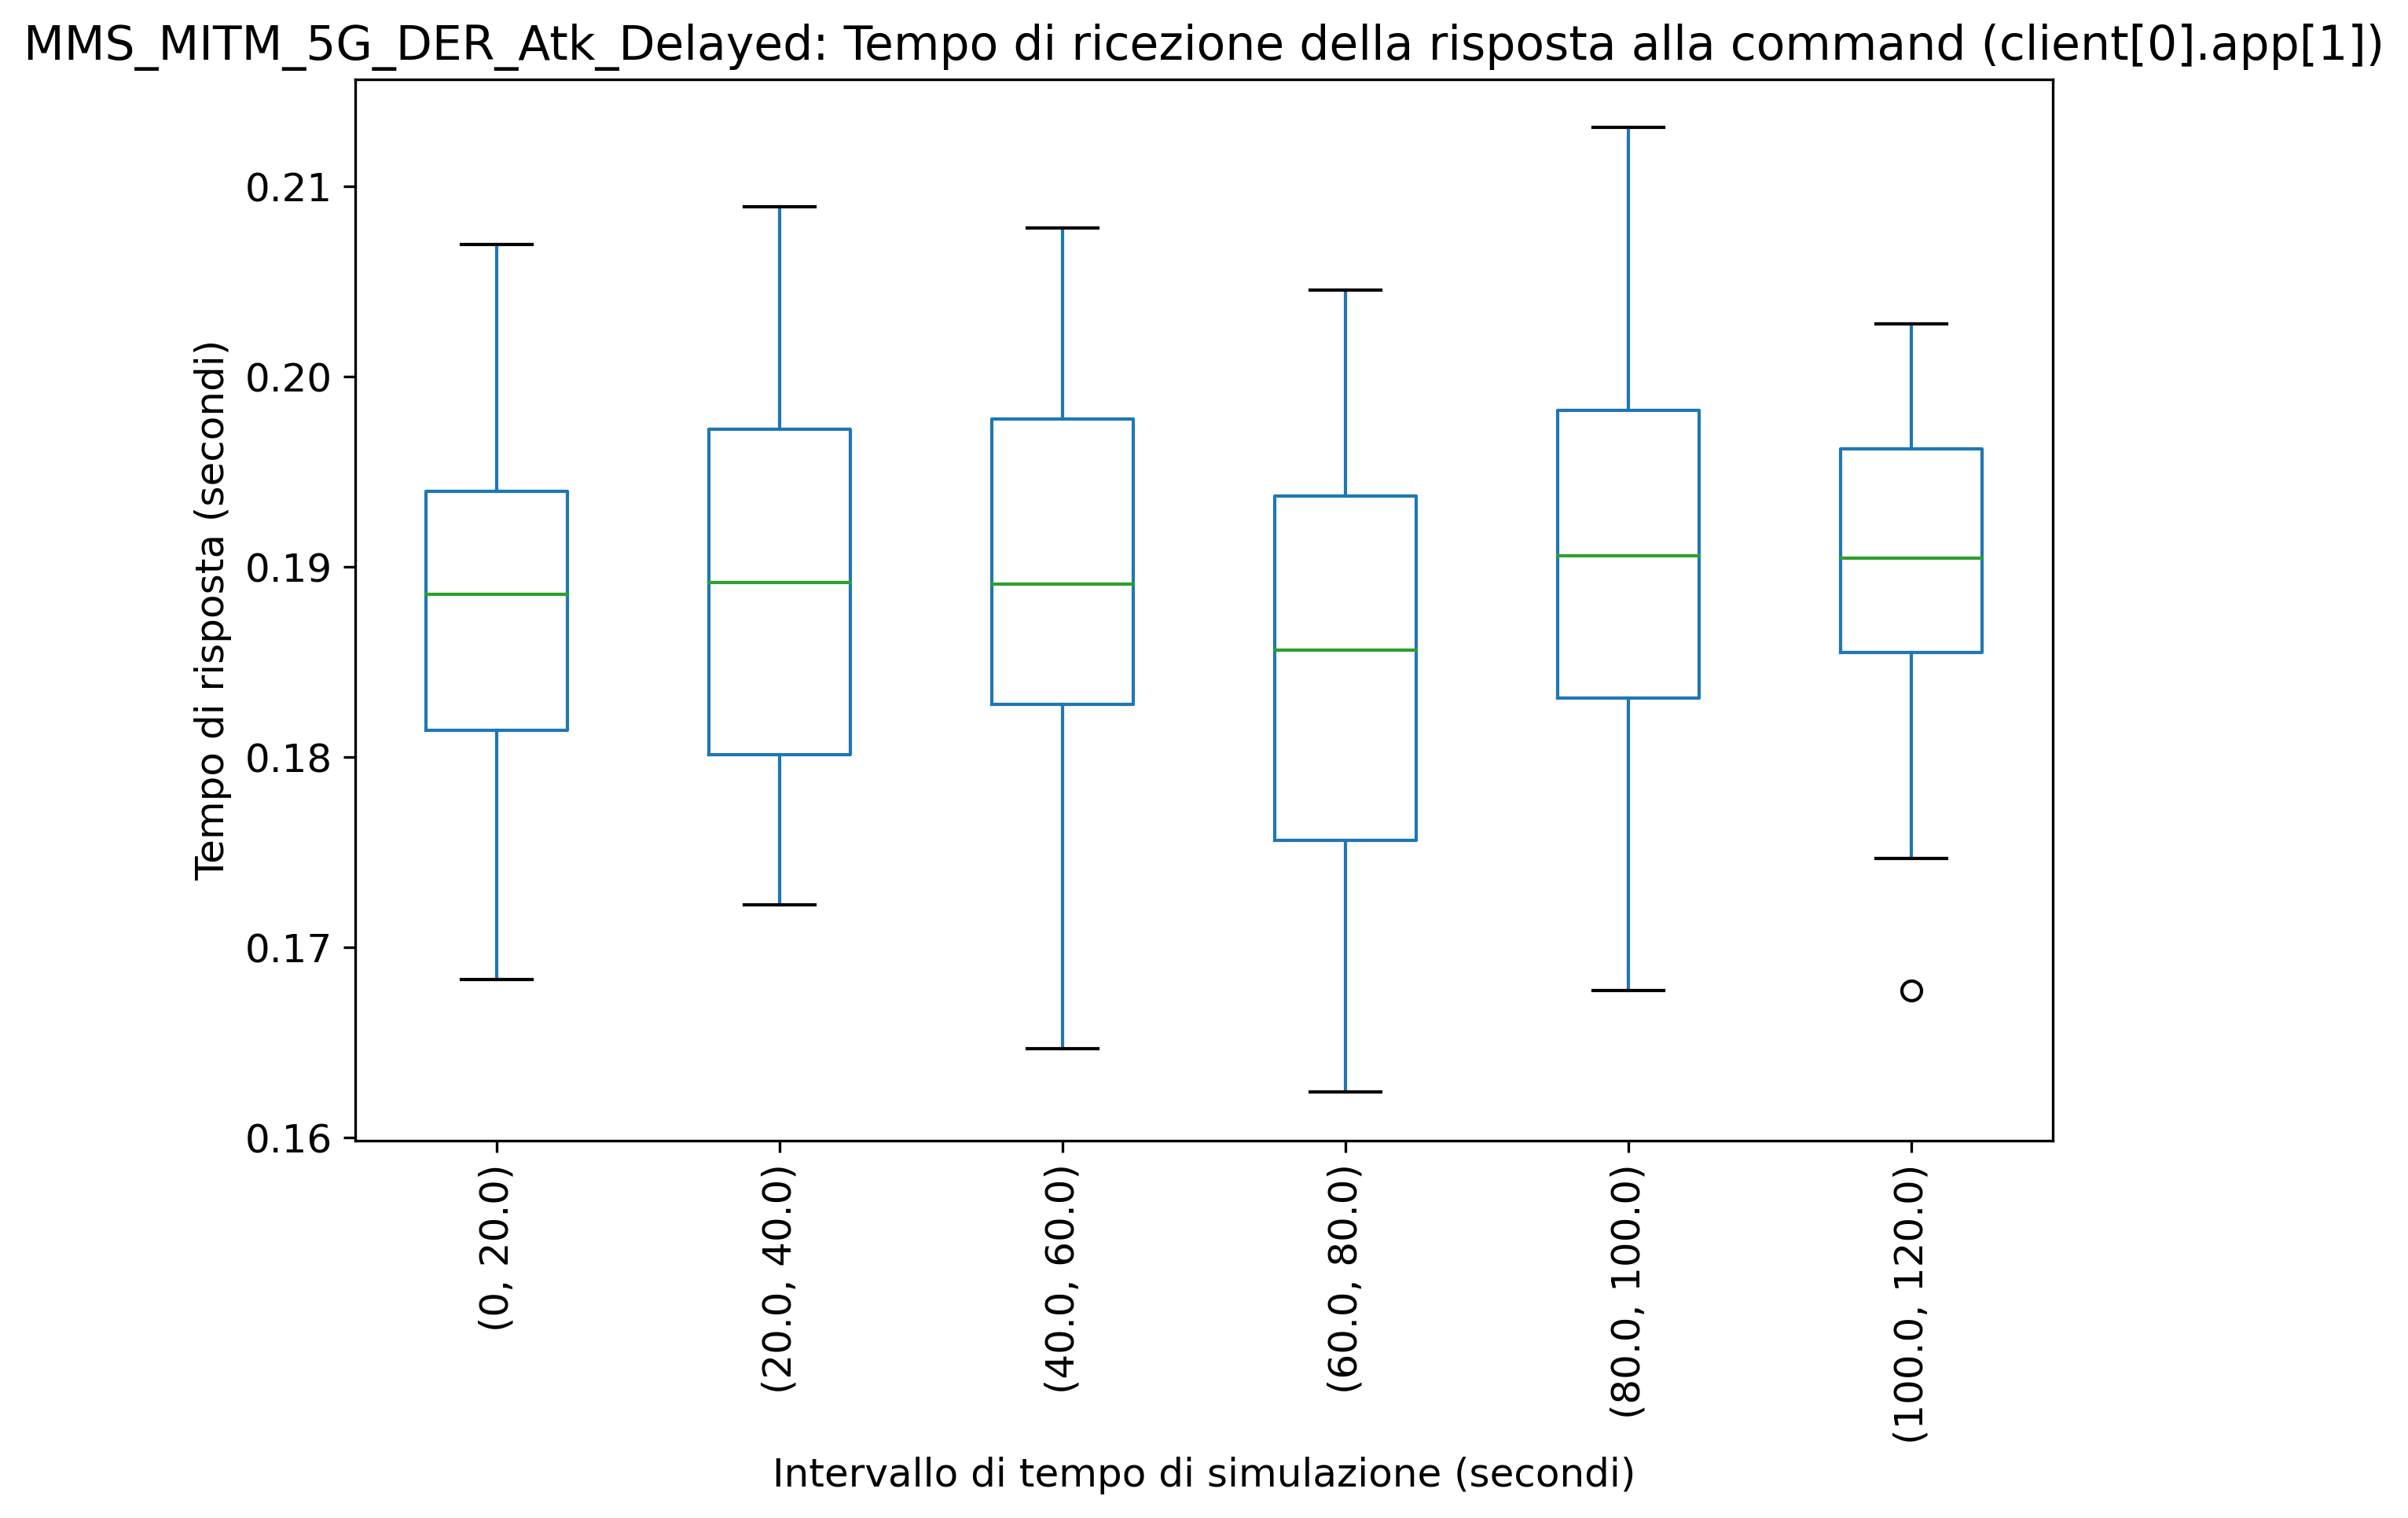

[]


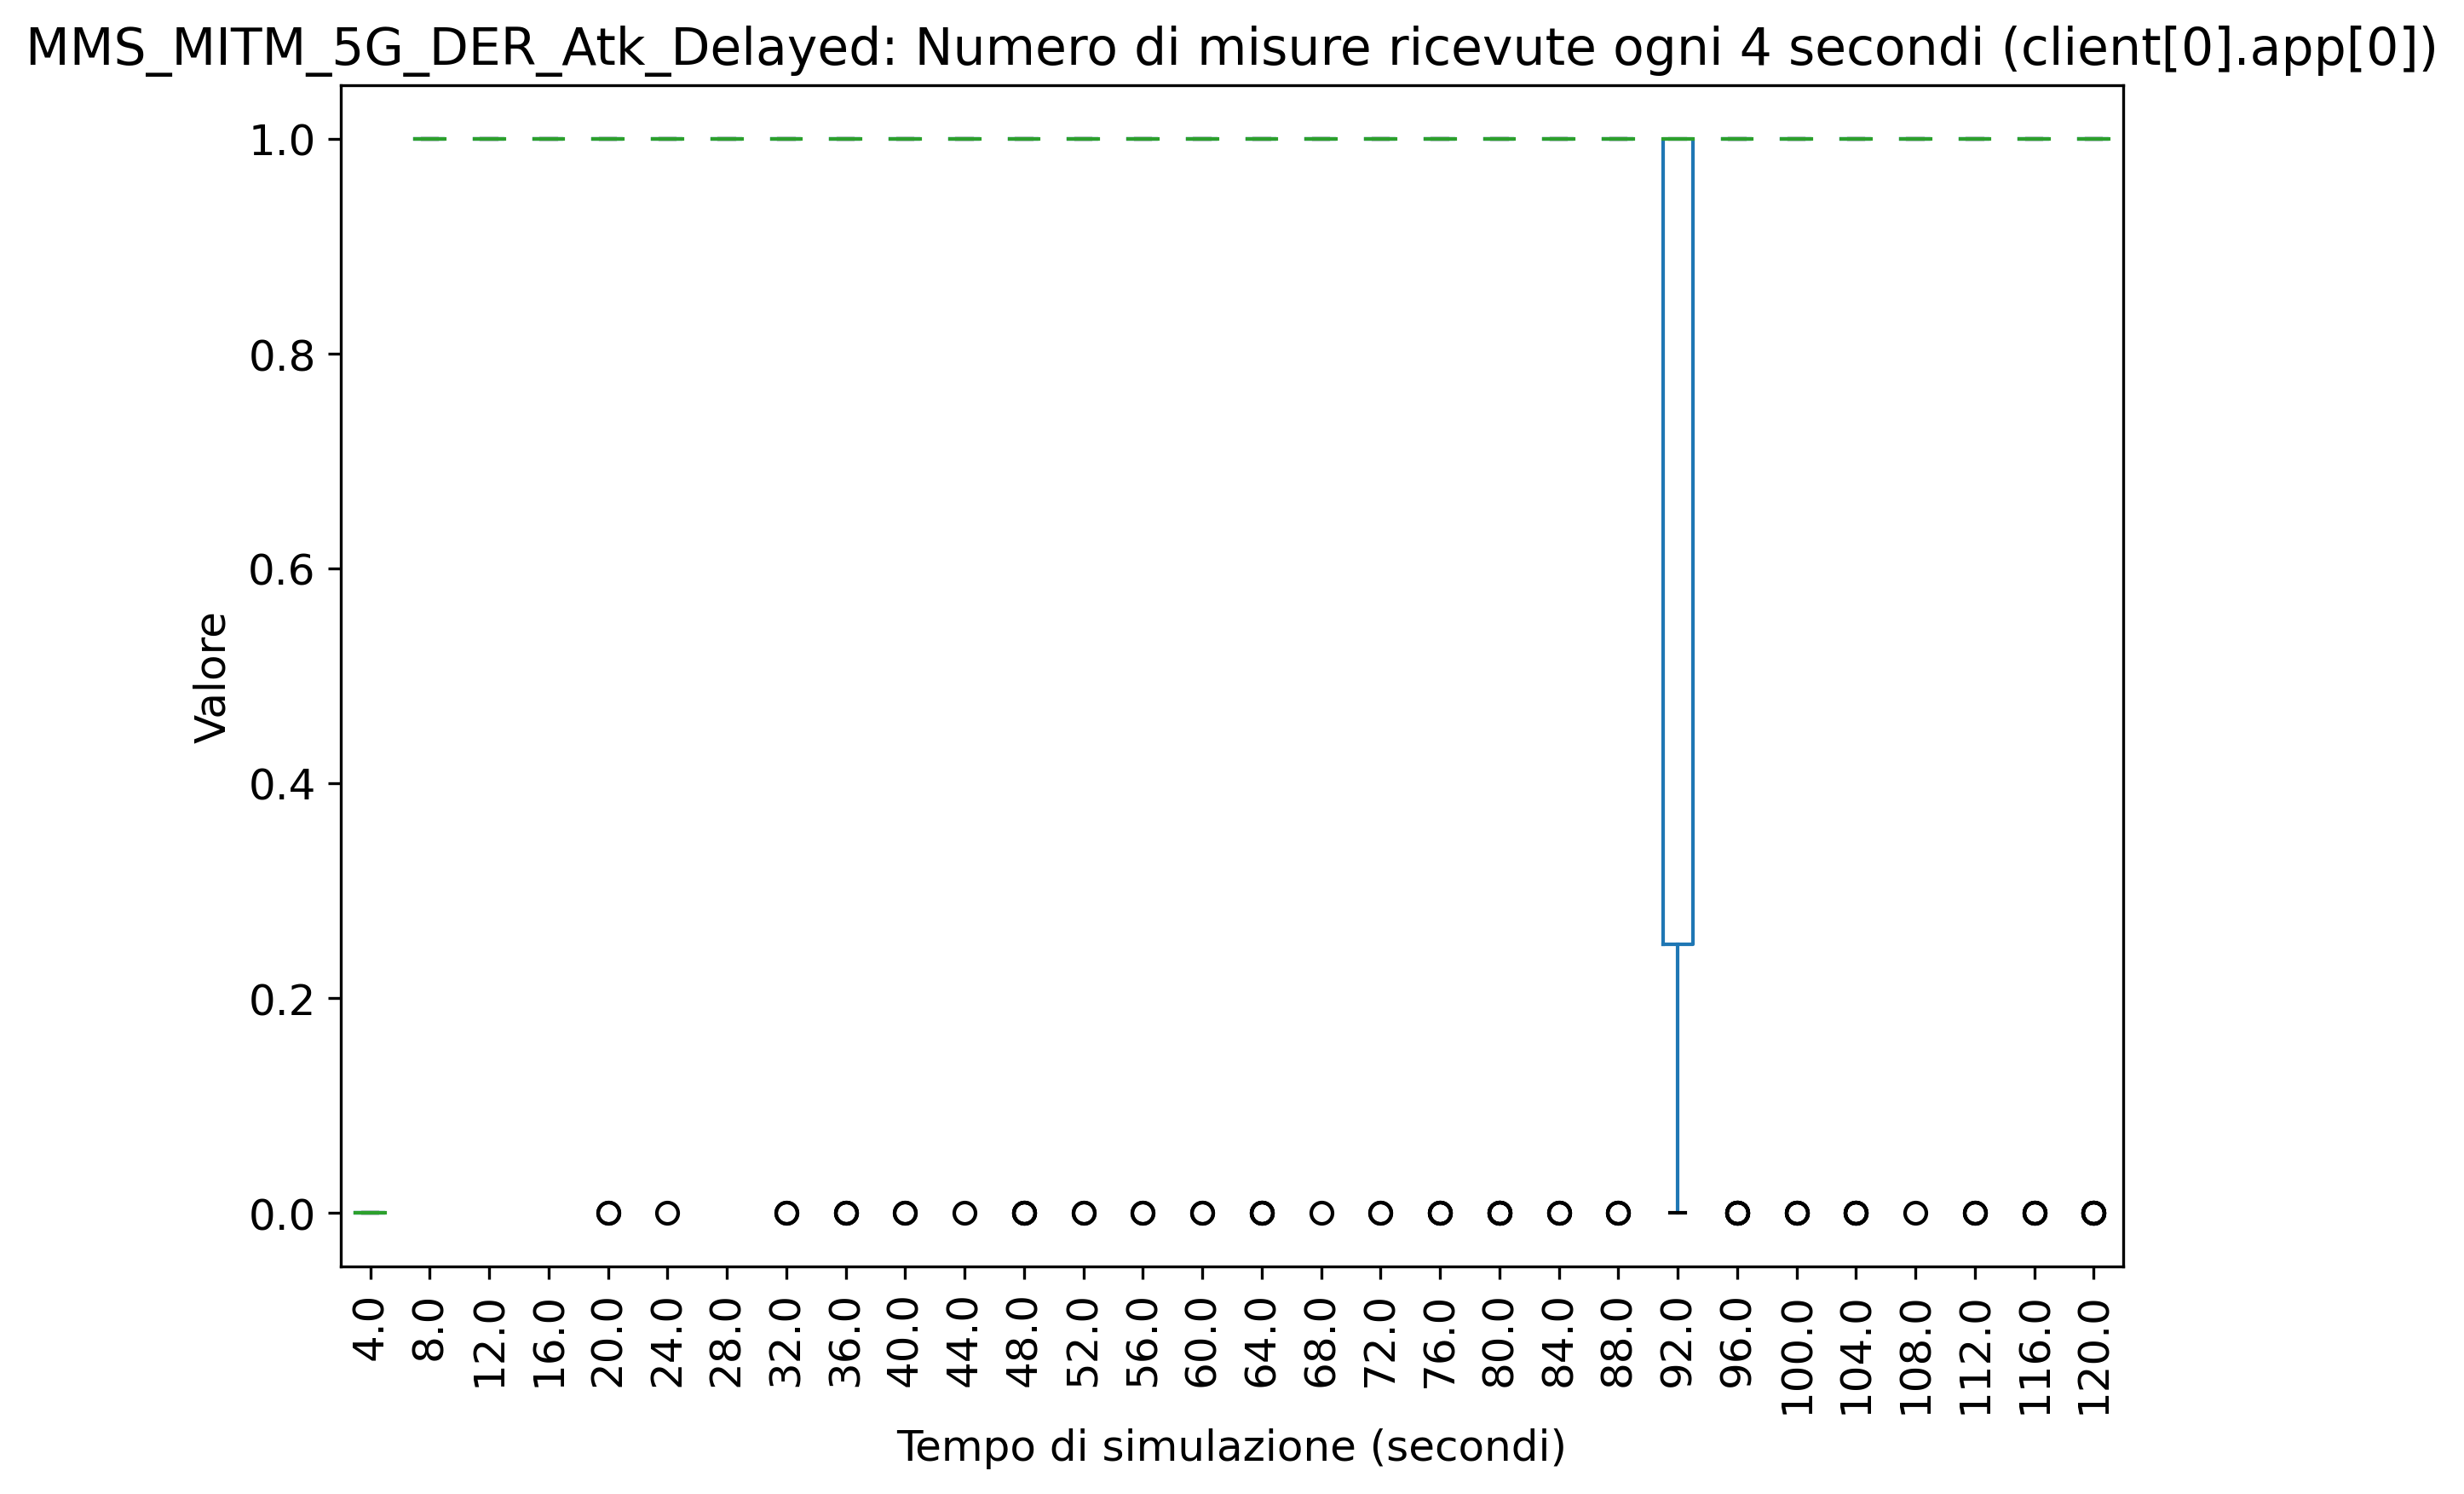

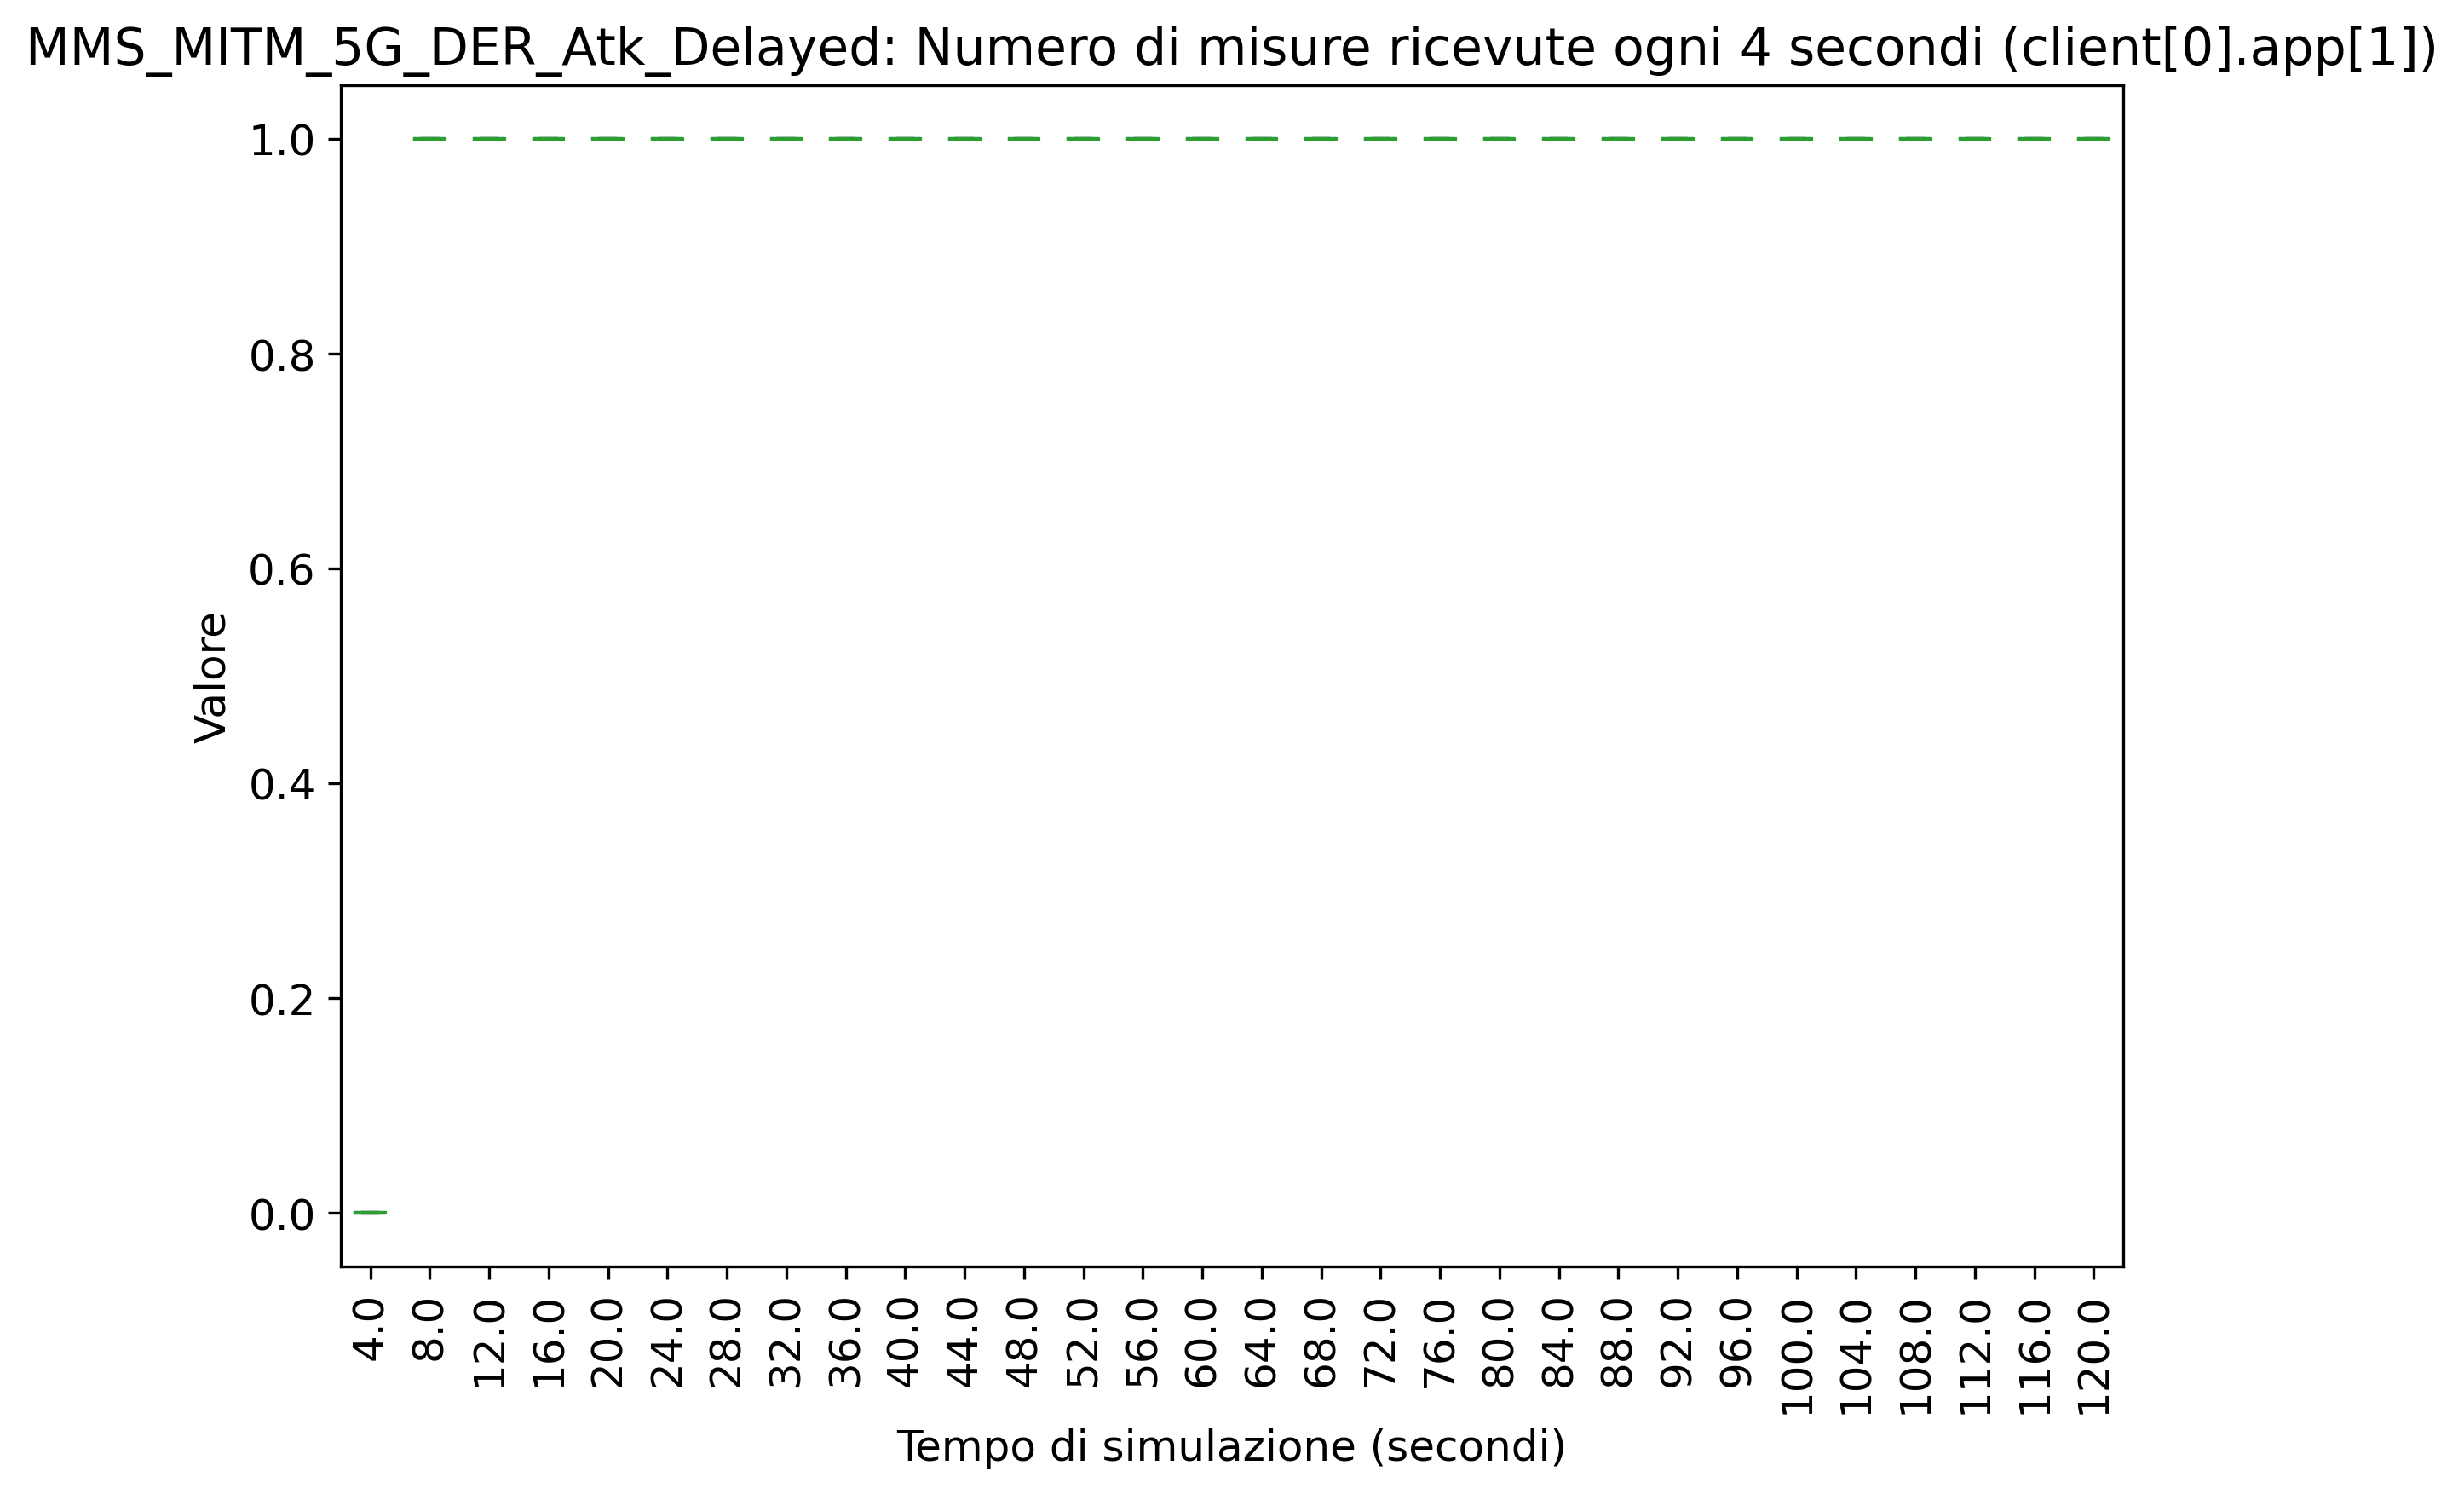

In [93]:
cliVecDfListReadTime = plotBoxWiskerVec(numClients, numServers, title=simName + ": Tempo di ricezione della risposta alla read", xLab = "Intervallo di tempo di simulazione (secondi)", yLab = "Tempo di risposta (secondi)", vecMeasName="readResponseReceivedTime", numRanges = 8)
cliVecDfListCommandTime = plotBoxWiskerVec(numClients, numServers, title=simName + ": Tempo di ricezione della risposta alla command", xLab = "Intervallo di tempo di simulazione (secondi)", yLab = "Tempo di risposta (secondi)", vecMeasName="commandResponseReceivedTime", numRanges = 6)
cliVecDfListMeasRec = plotBoxWiskerVec(numClients, numServers, title=simName + ": Numero di misure ricevute ogni 4 secondi", xLab = "Tempo di simulazione (secondi)", yLab = "Valore", vecMeasName="measureReceivedAmount", numRanges = 0)

In [94]:
def plotPointsVec(numClients, numServers, title = "", xLab = "", yLab = "", cli = "client", vecMeasName = "measureReceivedAmount"):
    
    outVec = list()
    for i in range(numClients):
        for j in range(numServers):
            fig, axes = plt.subplots(nrows=1, ncols=1)
            fig.set_figheight(6)
            fig.set_figwidth(9)
            strElem = ""
            if cli == "evilClient":
                strElem = cli + ".app[" + str(j) + "]"
            else:
                strElem = cli + "[" + str(i) + "].app[" + str(j) + "]"
            
            flt = vec[vec["name"].str.contains(vecMeasName + ":" + StatType.VECTOR.value)]
            flt = flt[flt["module"].str.endswith(strElem)]
            
            colPlot = pd.DataFrame(columns=["value", "time", "color"])
            rowNum = 0
            colors = cm.rainbow(np.linspace(0, 1, len(flt["runID"])))
            for row, color in zip(flt.itertuples(), colors):
                vecValue = pd.Series(row.vecvalue)
                vecTime = pd.Series(row.vectime)
                for val, time in zip(vecValue, vecTime):    
                    colPlot.loc[rowNum] = list((val, time, color))
                    rowNum += 1
                                
            outVec.append(colPlot)
            if DEBUG:
                colPlot.to_csv("./out.csv", mode="w", header=True)

            axes.scatter("time", "value", data=colPlot, c="blue")#colPlot["color"]
            axes.set_title(title + " (" + strElem + ")", fontstyle='italic') 
            axes.set_xlabel(xLab)
            axes.set_ylabel(yLab)  
            print("Avg: " + str(np.mean(colPlot["value"])))   
            print("Std: " + str(np.std(colPlot["value"]))) 
            interval = scipy.stats.t.interval(0.98, df=len(colPlot["value"])-1, loc=np.mean(colPlot["value"]), scale=scipy.stats.sem(colPlot["value"]))
            print("Confidence interval at 98%: " + str((interval[1] - interval[0])/2))
            print("****")            
    return outVec

Avg: 0.2409612110934385
Std: 0.05129300096601054
Confidence interval at 98%: 0.006926253002039112
****
Avg: 0.2020246758327725
Std: 0.04756060584852659
Confidence interval at 98%: 0.005722707332612181
****
Avg: 0.22526619737144846
Std: 0.013826641307753615
Confidence interval at 98%: 0.0023347128106120107
****
Avg: 0.18871649820272426
Std: 0.010795227056868854
Confidence interval at 98%: 0.0016251152906352206
****


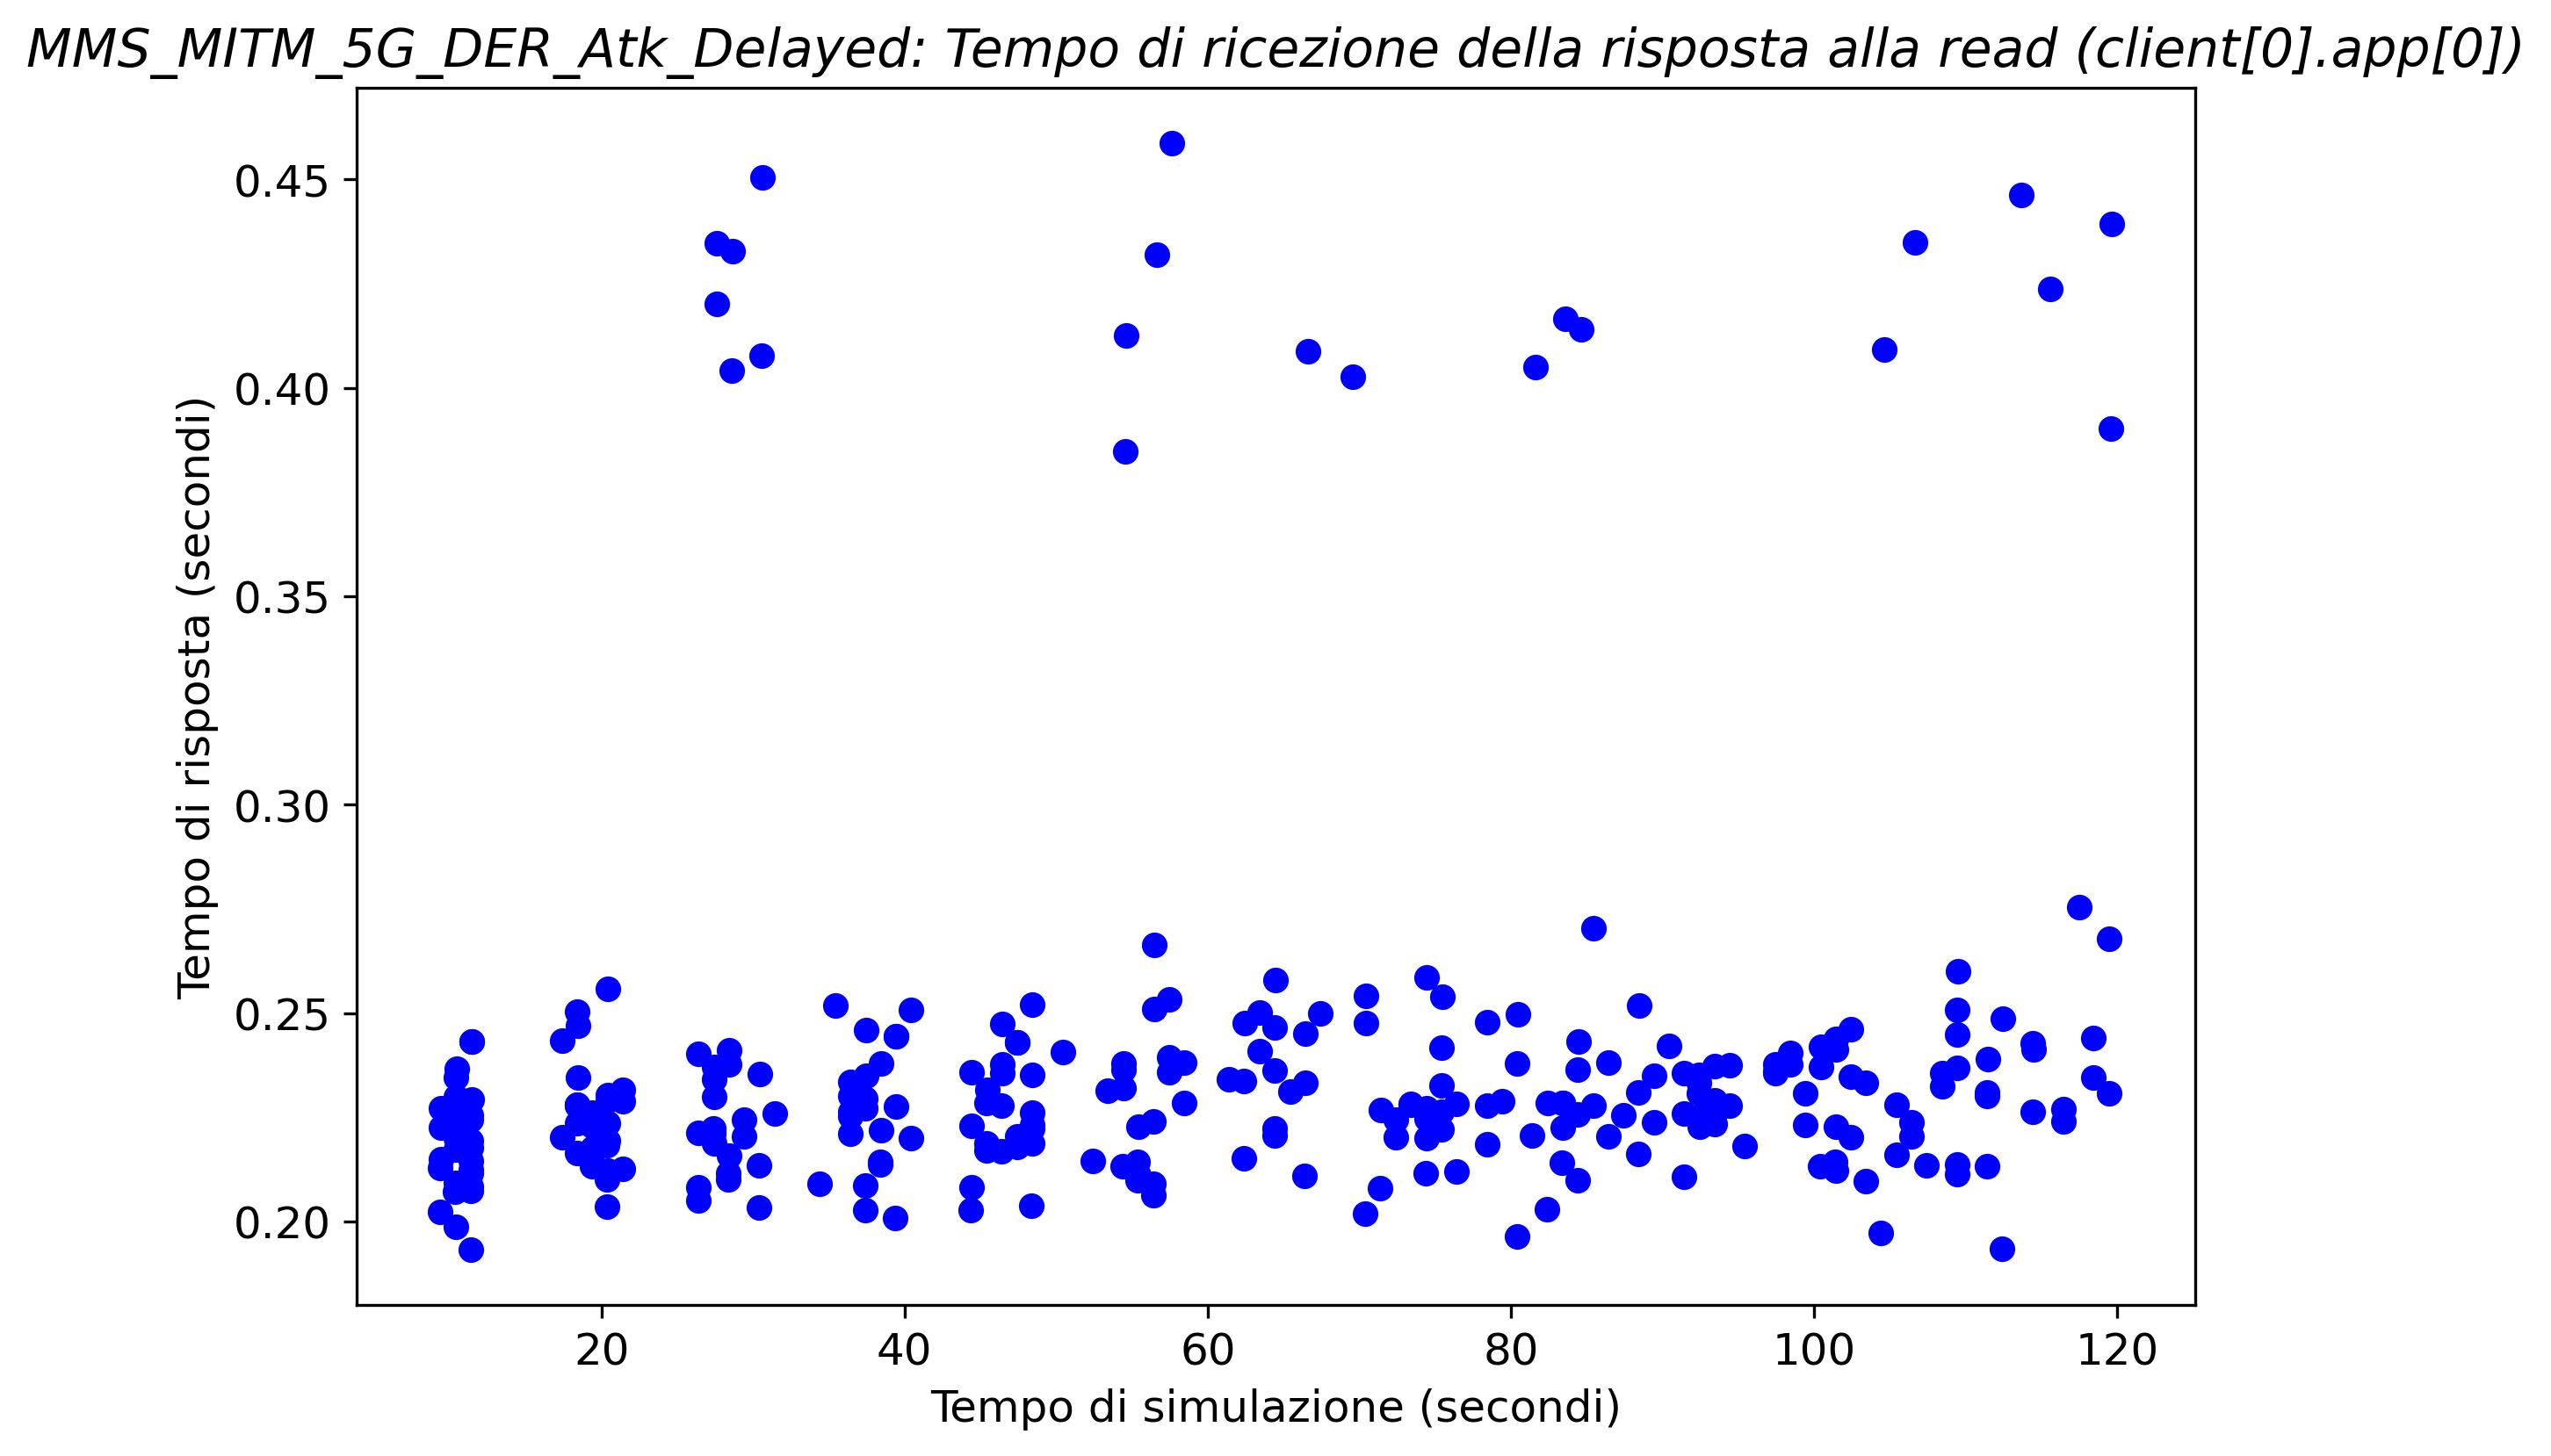

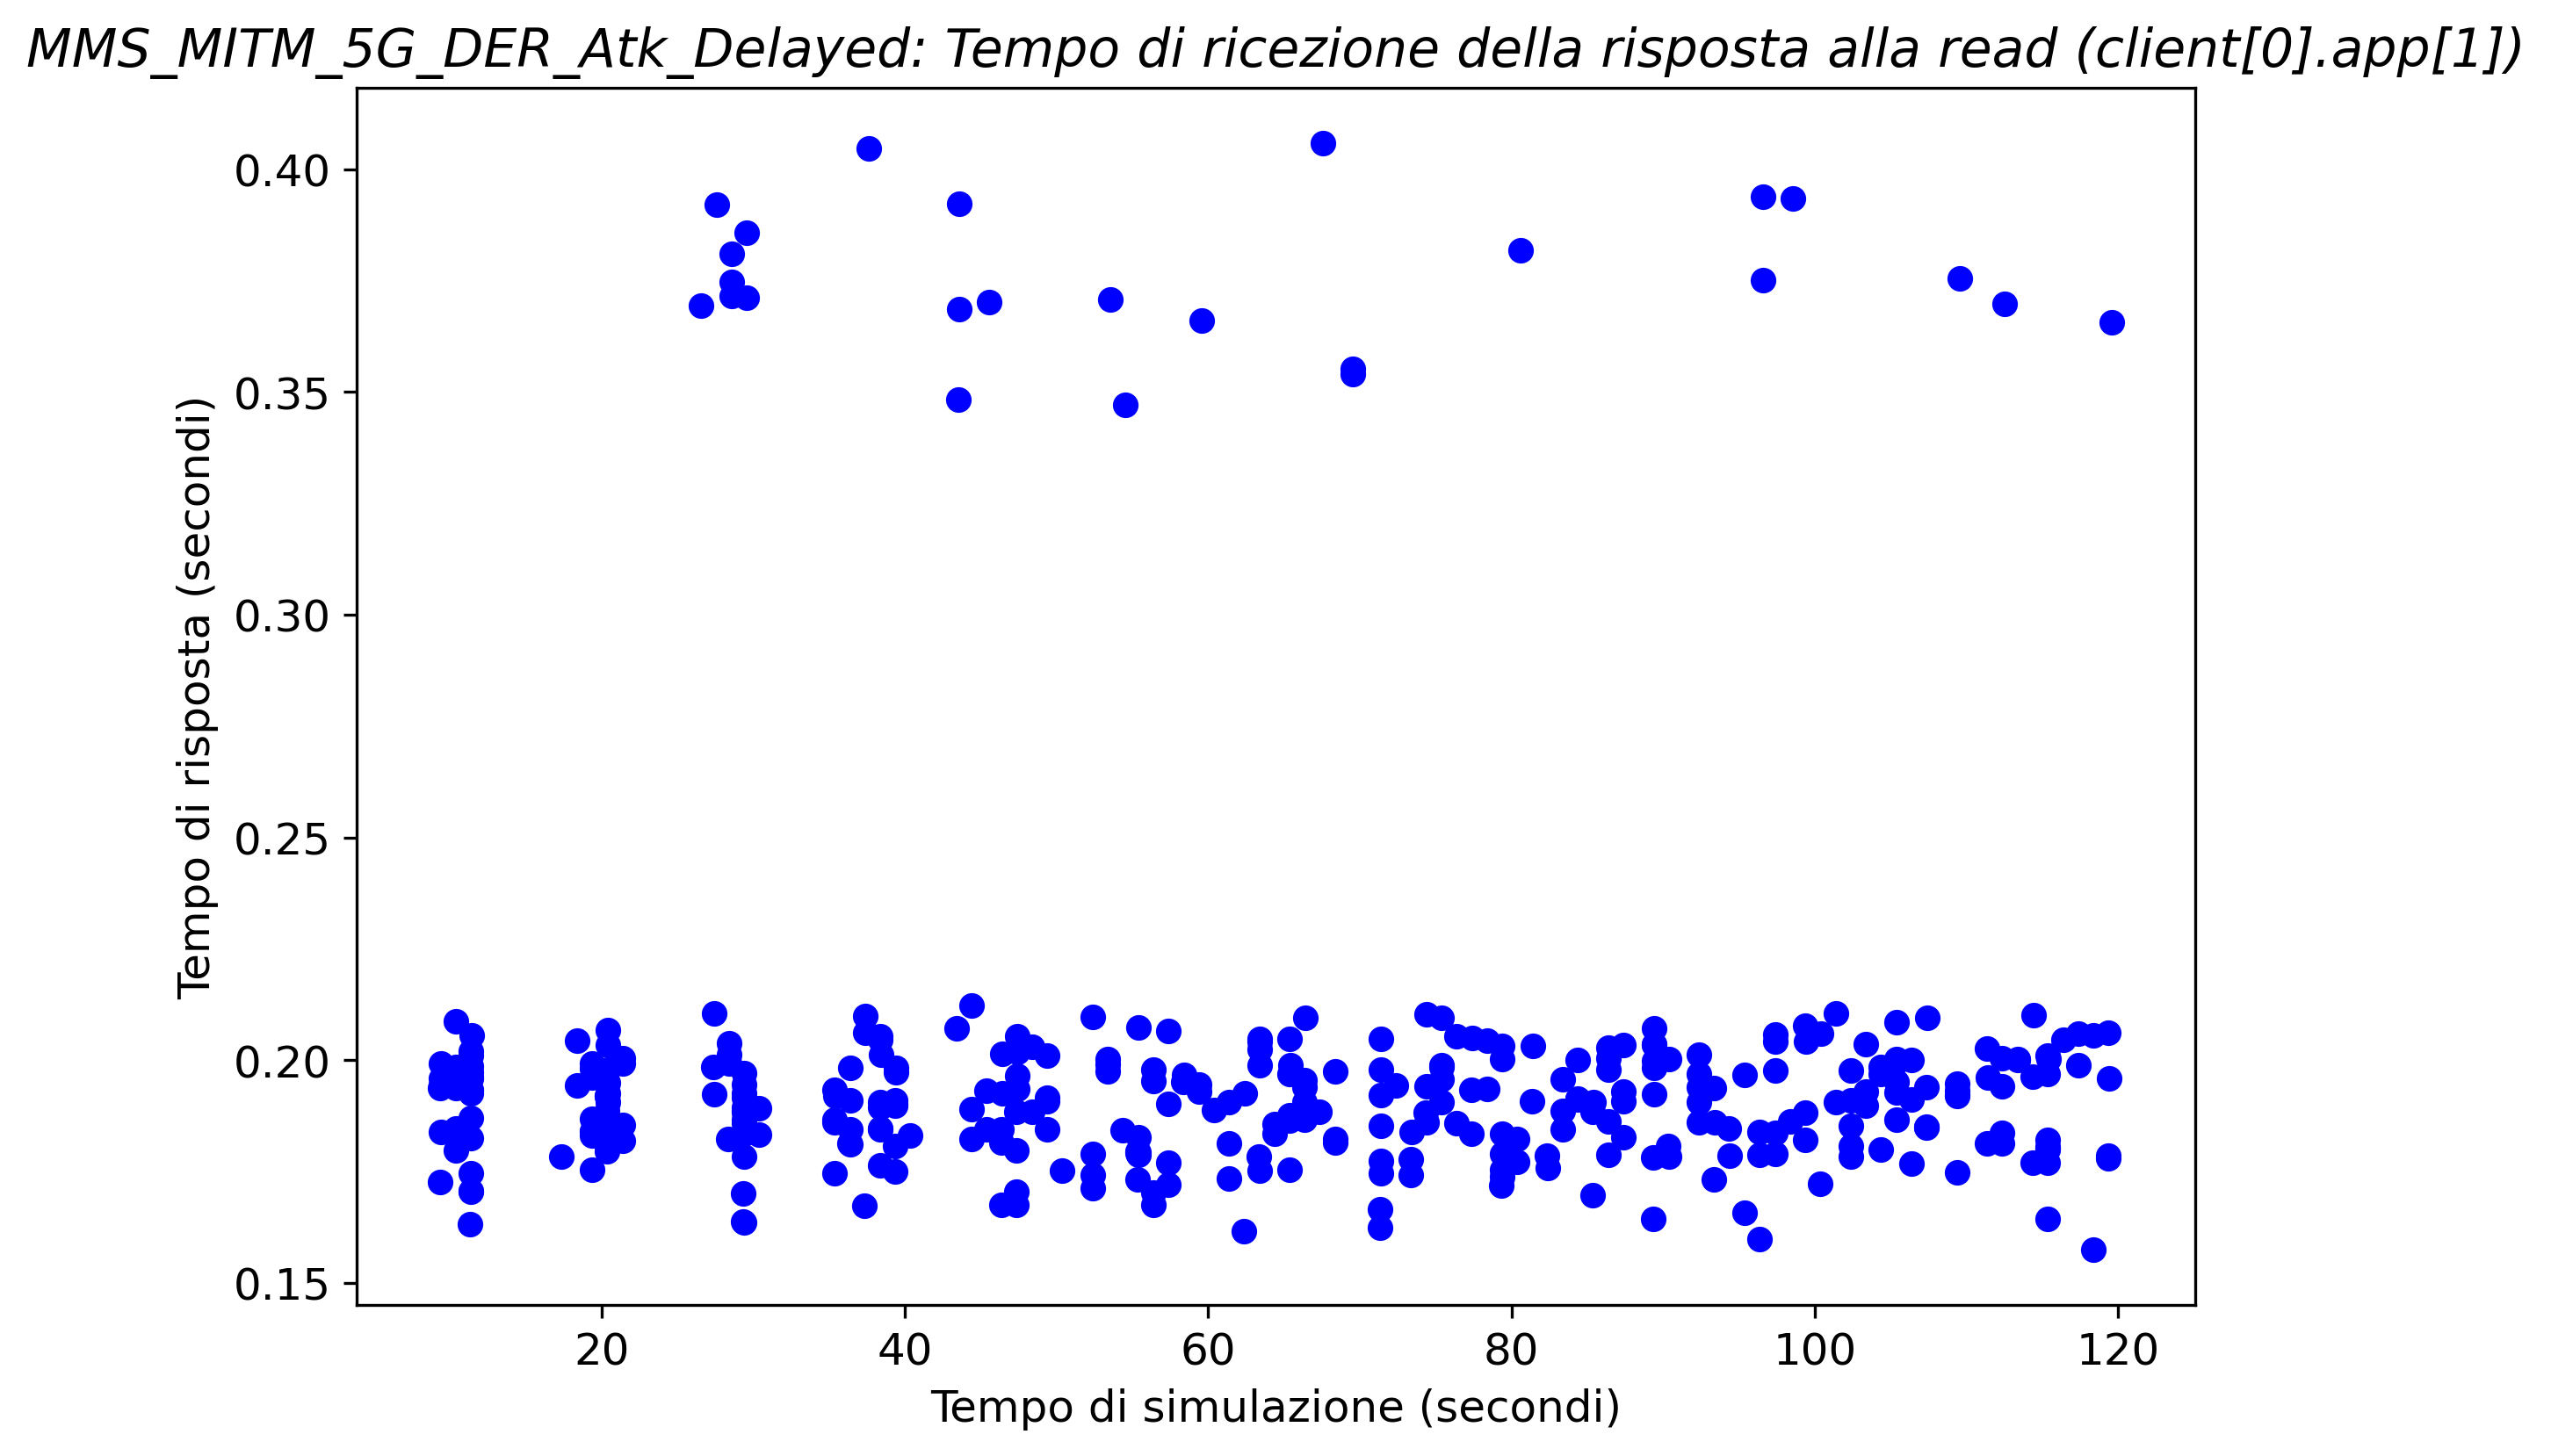

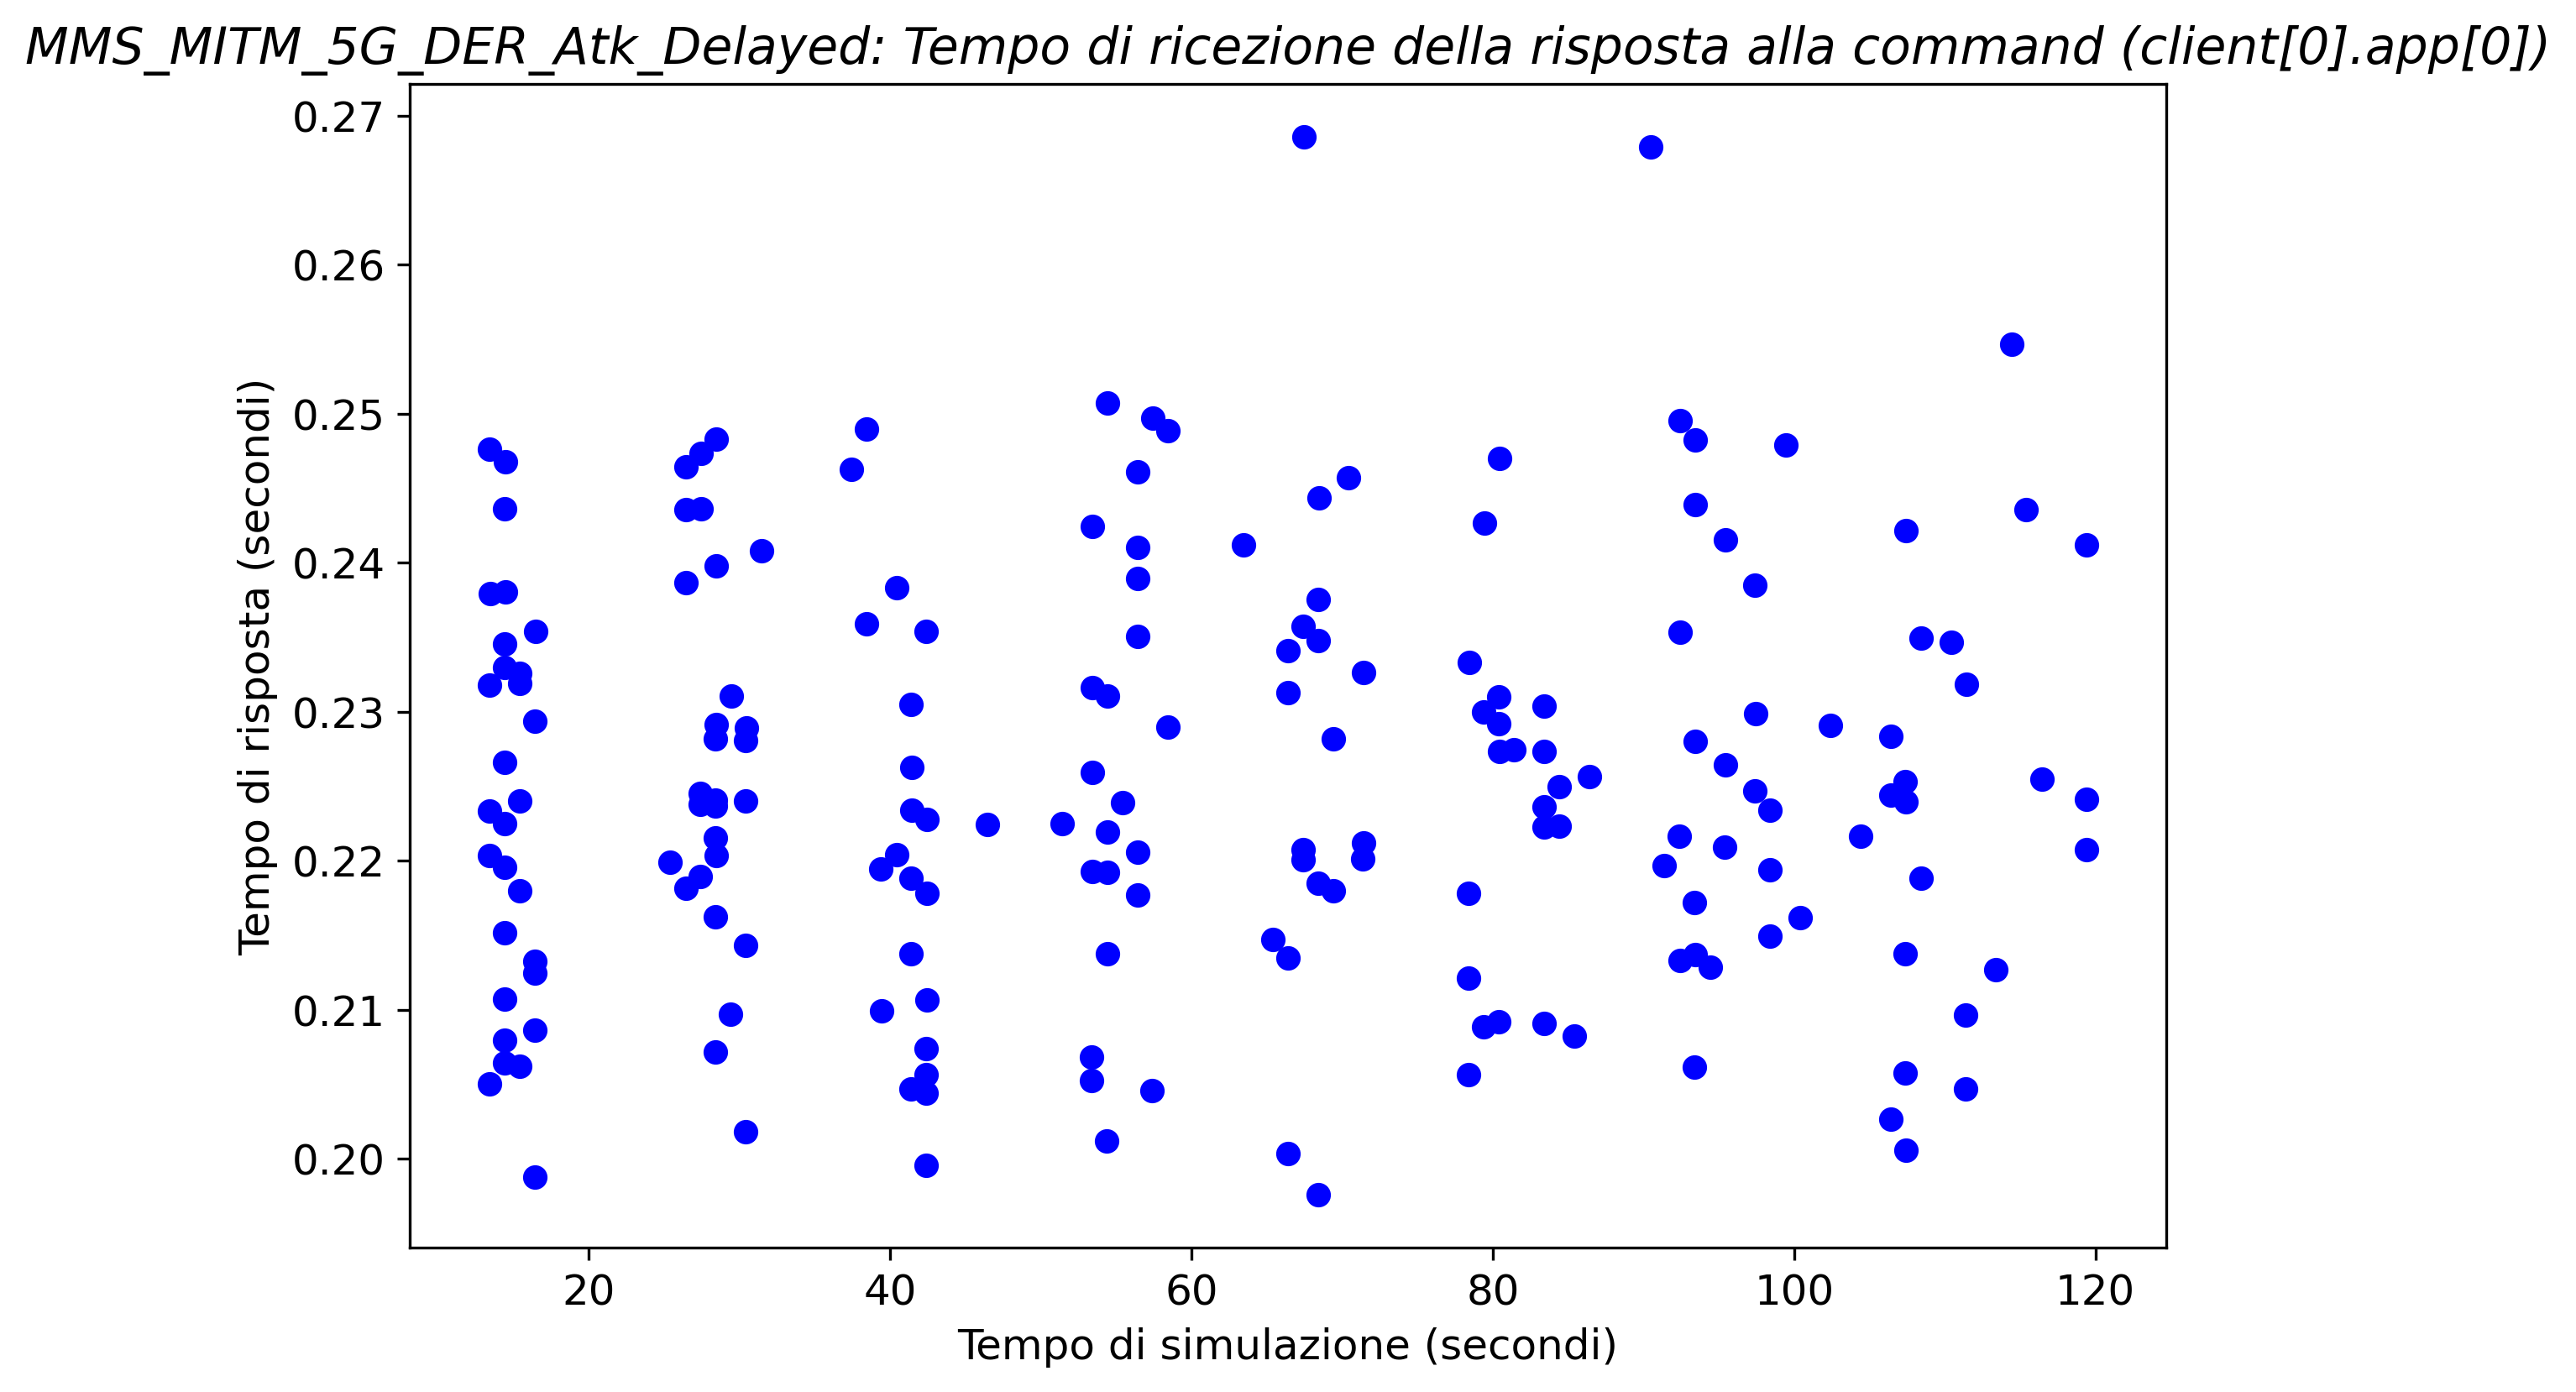

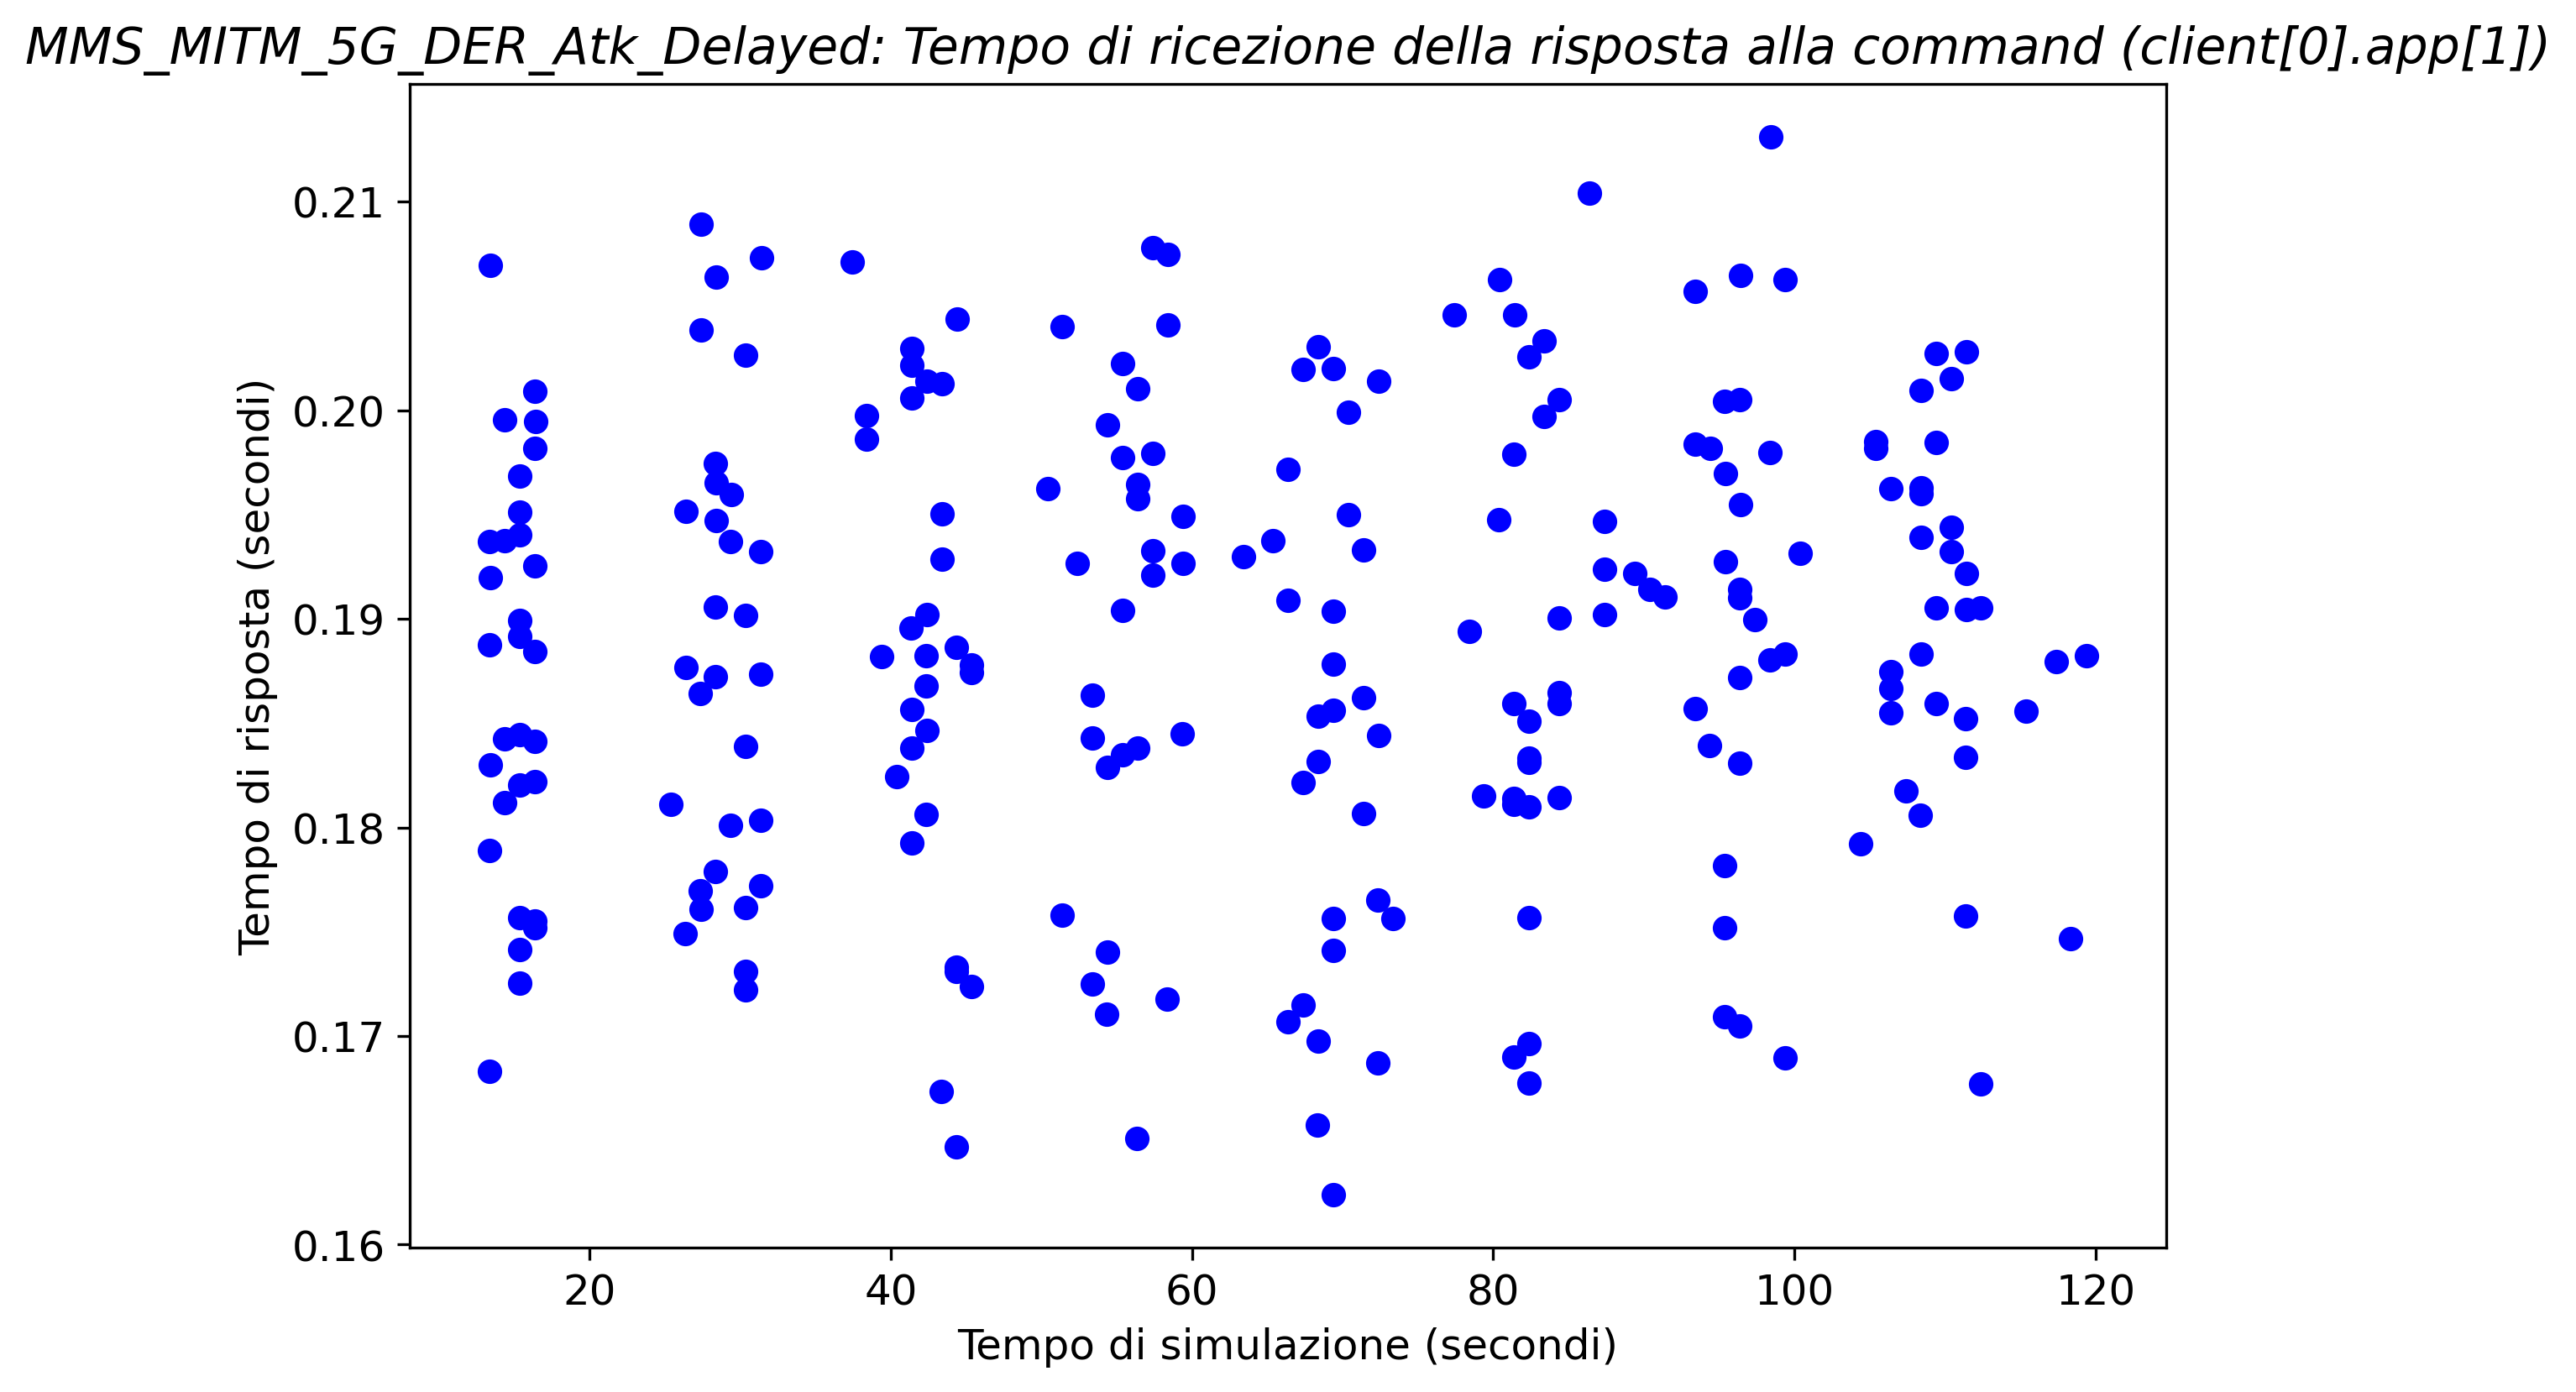

In [95]:
cliVecDfListReadTimeSingles = plotPointsVec(numClients, numServers, title=simName + ": Tempo di ricezione della risposta alla read", xLab="Tempo di simulazione (secondi)", yLab="Tempo di risposta (secondi)", vecMeasName="readResponseReceivedTime")
cliVecDfListCommandTimeSingles = plotPointsVec(numClients, numServers, title=simName + ": Tempo di ricezione della risposta alla command", xLab="Tempo di simulazione (secondi)", yLab="Tempo di risposta (secondi)", vecMeasName="commandResponseReceivedTime")

In [96]:
def confidenceInterval(data, confidence = 0.95):
    for (colName, colData) in data.iteritems():
        a = 1.0 * np.array(colData.values)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * np.abs(scipy.stats.t.ppf((1-confidence)/2.0, n-1))
        relAcc = (h / m) * 100
        
        # m, m-h, m+h
        print("## Stat: " + colName)
        print("Average: " + str(round(m, 2)))
        print("Quantile: +-" + str(round(h, 2)))
        print("Relative accuracy: " + str(round(relAcc, 2)) + " %")
        if DEBUG:   
            interval = scipy.stats.t.interval(confidence, df=n-1, loc=m, scale=se)
            print("Debug interval: " + str((interval[1] - interval[0])/2))
         

Confidence interval for the different statistics

In [97]:
conf = 0.95
for i in range(numClients):
    for j in range(numServers):
        print("\n** " + simName + ": Confidence intervals for client[" + str(i) + "].app[" + str(j) + "] at " + str(conf*100) + "%  **")
        confidenceInterval(cliScaDfList[(i+1)*j], conf)


** MMS_MITM_5G_DER_Atk_Delayed: Confidence intervals for client[0].app[0] at 95.0%  **
## Stat: readSent
Average: 12.63
Quantile: +-0.18
Relative accuracy: 1.45 %
Debug interval: 0.18301848999121795
## Stat: commandSent
Average: 8.17
Quantile: +-0.14
Relative accuracy: 1.73 %
Debug interval: 0.14153923086833586
## Stat: readResponse
Average: 10.03
Quantile: +-0.59
Relative accuracy: 5.9 %
Debug interval: 0.5923040545661493
## Stat: commandResponse
Average: 6.47
Quantile: +-0.52
Relative accuracy: 7.99 %
Debug interval: 0.5164145687152324
## Stat: readResponseTimeout
Average: 2.2
Quantile: +-0.47
Relative accuracy: 21.56 %
Debug interval: 0.4743570709094098
## Stat: commandResponseTimeout
Average: 1.53
Quantile: +-0.45
Relative accuracy: 29.12 %
Debug interval: 0.44651084842589306

** MMS_MITM_5G_DER_Atk_Delayed: Confidence intervals for client[0].app[1] at 95.0%  **
## Stat: readSent
Average: 12.6
Quantile: +-0.19
Relative accuracy: 1.48 %
Debug interval: 0.18605815084444544
## Stat: 

/tmp/ipykernel_15460/2305554413.py:7: RuntimeWarning: invalid value encountered in double_scalars
  relAcc = (h / m) * 100
/home/dosclic98/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/dosclic98/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [98]:
for j in range(numServers):
    print("\n** " + simName + ": Confidence intervals for evilClient.app[" + str(j) + "] at " + str(conf*100) + "%  **")
    confidenceInterval(evilScaDfList[j], conf)
    


** MMS_MITM_5G_DER_Atk_Delayed: Confidence intervals for evilClient.app[0] at 95.0%  **
## Stat: measureBlock
Average: 2.7
Quantile: +-0.63
Relative accuracy: 23.3 %
Debug interval: 0.6290459488265161
## Stat: measureCompromised
Average: 8.03
Quantile: +-0.92
Relative accuracy: 11.42 %
Debug interval: 0.9171916898394827
## Stat: readRequestBlock
Average: 1.93
Quantile: +-0.58
Relative accuracy: 29.98 %
Debug interval: 0.5795854361288318
## Stat: readRequestCompromised
Average: 4.5
Quantile: +-0.63
Relative accuracy: 13.91 %
Debug interval: 0.6259811513065632
## Stat: commandRequestBlock
Average: 1.0
Quantile: +-0.37
Relative accuracy: 36.69 %
Debug interval: 0.3669116215639084
## Stat: commandRequestCompromised
Average: 3.27
Quantile: +-0.48
Relative accuracy: 14.69 %
Debug interval: 0.4797323934379496
## Stat: readResponseBlock
Average: 0.67
Quantile: +-0.32
Relative accuracy: 47.28 %
Debug interval: 0.3152228342284368
## Stat: readResponseCompromised
Average: 4.33
Quantile: +-0.72
R

/tmp/ipykernel_15460/2305554413.py:7: RuntimeWarning: invalid value encountered in double_scalars
  relAcc = (h / m) * 100
